# GridSearch Best Params 5CV + stem words + upsampling (App 8)

## 1) Import Packages

In [7]:
### BASIC PACKAGES
import pandas as pd
import numpy as np

### SKLEARN'S MACHINE LEARNING MODELS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

### METRICS CALCULATION
from sklearn import metrics

### SPACY'S STOP WORDS
from spacy.lang.en.stop_words import STOP_WORDS

### NLTK STEMMER
from nltk.stem.snowball import SnowballStemmer

### VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [8]:
new_stop_words = list(STOP_WORDS)
new_stop_words.append("buy")
print(sorted(new_stop_words))

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'buy', 'by', 'ca', 'call', 'can', 'cannot', 'could', 'did', 'do', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'h

## 2) ML with CV

In [13]:
# Pre-Processing:
# X = X or predictor variables, 1-D list or np.array
# y = y or target variables, 1-D list or np.array
# vect = CountVectorizer Text Preprocessor, needed for Text Analysis Machine Learning Model, CountVectorizer
# model = Machine Learning Model (E.g. Multinomial Naive Bayes, Linear SVC, LogisticRegression), sklearn ml model
# n_runs = Number of Runs to execute, int
# split_size = K fold Cross Validation, int
# print_itr = condition to print the iterations 

# Post-Processing:
# index = Index Labels of the data in the form of iter{iteration int}_cv_split{cv_split int}, list of int
# full_buy_words = list of lists of top 10 words in predicting label: "Buy", list of list of str
# full_sell_words = list of lists of top 10 words in predicting label: "Sell", list of list of str
# full_train_aucs = List of Areas Under Curve in predicting Training set data, list of float
# full_test_aucs = List of Areas Under Curve in predicting Testing set data, list of float
# full_train_accs = List of Accuracy Scores in predicting Training set data, list of float
# full_test_accs = List of Accuracy Scores in predicting Testing set data, list of float
# full_train_null_accs = List of Null Accuracy Scores in predicting Training set data, list of float
# full_test_null_accs = List of Null Accuracy Scores in predicting Testing set data, list of float
# full_test_conf_mats = Array of Confusion Matrix under the Test set, Numpy Array
# full_train_conf_mats = Array of Confusion Matrix under the Train set, Numpy Array

def ml_cv(X, y, vect, model, n_runs, split_size, print_itr):
    
    n_rows = len(y)

    ### RESULTS LISTS ###
    full_buy_words = []
    full_neut_words = []
    full_sell_words = []

    full_train_accs = []
    full_test_accs = []

    #full_train_aucs = []
    #full_test_aucs = []
    
    full_train_null_accs = []
    full_test_null_accs = []
    
    full_train_conf_mats = []
    full_test_conf_mats = []
    
    index = []
    
    classes = sorted(list(set(y)))
    
    class_pos_dict = {}
    all_pos_classes = []
    for c, ind in zip(classes, range(len(classes))):
        all_pos_classes.append([a for a in range(len(y)) if y[a] == c])
        class_pos_dict[c] = ind

    all_cv_splits_classes = []
    for c, all_pos_c in zip(classes, all_pos_classes):
        cv_splits_curr_c = [len(split_amts) for split_amts in np.array_split(list(range(len(all_pos_c))), split_size)]
        all_cv_splits_classes.append(cv_splits_curr_c)
    
    for i in range(n_runs):
        if(print_itr):
            print("Run: {curr_run} out of {n_runs}".format(curr_run = i+1, n_runs = n_runs))
        
        all_pos = range(len(y))
        
        all_cv_set_pos_classes = []
        for c in classes:
            all_cv_set_pos_classes.append([a for a in range(len(y)) if y[a] == c])
        
        for cv in range(split_size):
            if(print_itr):
                print("Cross Validation: {curr_split} out of {split_size}".format(curr_split = cv + 1, split_size = split_size))
            
            test_pos = []
            
            if cv == split_size - 1:
                for ls in all_cv_set_pos_classes:
                    test_pos = test_pos + ls
            else:
                all_test_pos_classes = []
                for c in classes:
                    all_test_pos_classes.append(list(np.random.choice(all_cv_set_pos_classes[class_pos_dict[c]], 
                                                                      size = all_cv_splits_classes[class_pos_dict[c]][cv], 
                                                                      replace=False)))
                for ls in all_test_pos_classes:
                    test_pos = test_pos + ls

            train_pos = list(set(all_pos) - set(test_pos))
            
            #print("train: ", train_pos, len(train_pos))
            #print("test: ", test_pos, len(test_pos))
            #print("Everything", list(set(train_pos + test_pos)), len(list(set(train_pos + test_pos))))
            
            X_train = [X[a] for a in train_pos]
            X_test = [X[a] for a in test_pos]
            y_train = [y[a] for a in train_pos]
            y_test = [y[a] for a in test_pos]
            
            update_cv_set_pos_classes = []
            for cv_ls, test_ls in zip(all_cv_set_pos_classes, all_test_pos_classes):
                update_cv_set_pos_classes.append(list(set(cv_ls) - set(test_ls)))
            
            all_cv_set_pos_classes = update_cv_set_pos_classes
            
            ### UP SAMPLING AND SHUFFLING DONE HERE!!!
            #X_train, y_train = up_samp_data(X_train, y_train)
            #X_train, y_train = shuffle_data(X_train, y_train)
        
            #X_test, y_test = up_samp_data(X_test, y_test)
            #X_test, y_test = shuffle_data(X_test, y_test)
            
            X_train_dtm = vect.fit_transform(X_train)
            X_test_dtm = vect.transform(X_test)

            model.fit(X_train_dtm, y_train)
            
            # PREDICTION ACCURACY SCORES
            y_pred_test_class = model.predict(X_test_dtm)
            y_pred_train_class = model.predict(X_train_dtm)
            
            train_acc_score = metrics.accuracy_score(y_pred=y_pred_train_class, y_true=y_train)
            test_acc_score = metrics.accuracy_score(y_pred=y_pred_test_class, y_true=y_test)
            
            full_train_accs.append(train_acc_score)
            full_test_accs.append(test_acc_score)
            
            # CONFUSION MATRIX
            full_train_conf_mats.append(metrics.confusion_matrix(y_true = y_train, y_pred = y_pred_train_class, labels = classes))
            full_test_conf_mats.append(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred_test_class, labels = classes))
            
            # NULL ACCURACY SCORES
            train_classes = list(np.unique(y_train))
            test_classes = list(np.unique(y_test))
            
            train_most_occur_class = train_classes[1] if len([a for a in y_train if a == train_classes[1]])/len(y_train) >= 0.5 else train_classes[0]
            test_most_occur_class = test_classes[1] if len([a for a in y_test if a == test_classes[1]])/len(y_test) >= 0.5 else test_classes[0]
            
            train_null_acc = sum([1 for a in y_train if a == train_most_occur_class])/len(y_train)
            test_null_acc = sum([1 for a in y_test if a == test_most_occur_class])/len(y_test)
            
            full_train_null_accs.append(train_null_acc)
            full_test_null_accs.append(test_null_acc)
            
            # TOP 10 SELL, NEUTRAL AND BUY WORD PREDICTORS
            if 'coef_' in dir(model):
                #df = pd.DataFrame({'coef': model.coef_[0], 'word': vect.get_feature_names()})
                max_pos = [np.argmax(a) for a in model.coef_.transpose()]
                top_words_dicts = []
                for c in classes:
                    top_words_dicts.append({'coef': [], 'word': []})

                for coef_ls, word in zip(model.coef_.transpose(), vect.get_feature_names()):
                    top_words_dicts[np.argmax(coef_ls)]['coef'].append(np.max(coef_ls))
                    top_words_dicts[np.argmax(coef_ls)]['word'].append(word)
                
            elif 'feature_importances_' in dir(model):
                df = pd.DataFrame({'coef': model.feature_importances_, 'word': vect.get_feature_names()})
                
            
            sell_words_df = pd.DataFrame(top_words_dicts[0]).sort_values('coef', ascending=False)
            neut_words_df = pd.DataFrame(top_words_dicts[1]).sort_values('coef', ascending=False)
            buy_words_df = pd.DataFrame(top_words_dicts[2]).sort_values('coef', ascending=False)
            
            sell_words = list(sell_words_df.word[:10])
            neut_words = list(neut_words_df.word[:10])
            buy_words = list(buy_words_df.word[:10])

            full_sell_words.append(sell_words)
            full_neut_words.append(neut_words)
            full_buy_words.append(buy_words)
            
            # ITERATION AND SPLIT AS INDEXES
            curr_index = "iter{itr}_cv_split{cv_split}".format(itr = i + 1, cv_split = cv + 1)
            index.append(curr_index)
            
    return index, full_sell_words, full_neut_words, full_buy_words, full_train_accs, full_test_accs, full_test_null_accs, full_train_null_accs, full_test_conf_mats, full_train_conf_mats


## 3) Stem All Tweets

In [14]:
### READ ALL TWEETS DATA
all_tweets = pd.read_csv('all_tweets_data.csv')

### STEM ALL TWEETS
stemmer = SnowballStemmer("english")
new_tweets_stem = []
for twt in all_tweets['new_tweets']:
    stem_words = [stemmer.stem(word) for word in twt.split(" ")]
    new_sentence = stem_words[0]
    for word in stem_words[1:]:
        new_sentence = new_sentence + " " + word
    new_tweets_stem.append(new_sentence)

### ADD NEWLY STEMMED TWEETS TO DF
all_tweets['new_tweets_stem'] = pd.Series(new_tweets_stem)
all_tweets

,X,Buy/Neutral/Sell,tweets,replies,retweets,favs,user,timeStamp,new_tweets,new_dts,assigned_member,coinMentioned,termsMentioned,new_tweets_stem
0,1,0,"<a href=""/hashtag/Substratum?src=hash"" data-qu...",88.0,376.0,807.0,officialmcafee,2018-02-02 13:19:00,alpha ii video w in this video you see just ho...,1.517549e+09,daryl,False,True,alpha ii video w in this video you see just ho...
1,2,0,"<a href=""https://t.co/WLJYQmRqOK"" rel=""nofollo...",156.0,72.0,215.0,officialmcafee,2018-02-02 10:37:00,price increase,1.517539e+09,daryl,False,True,price increas
2,3,0,Looking for a woman with ex SOF military exper...,416.0,206.0,1300.0,officialmcafee,2018-02-02 06:32:00,looking for a woman with ex sof military exper...,1.517524e+09,daryl,True,True,look for a woman with ex sof militari experi t...
3,5,1,"Coin Brothers - ""Buy the Fucking Dip""\n\n<a hr...",296.0,401.0,1300.0,officialmcafee,2018-02-02 04:19:00,coin brothers buy the fucking dip via,1.517516e+09,daryl,False,True,coin brother buy the fuck dip via
4,6,1,Lot's of people asking me over the past two da...,984.0,2100.0,6000.0,officialmcafee,2018-02-02 04:12:00,lot's of people asking me over the past two da...,1.517516e+09,daryl,True,True,lot of peopl ask me over the past two day whet...
5,8,0,Call for White papers: There are more than 50 ...,320.0,203.0,960.0,officialmcafee,2018-02-01 16:23:00,call for white papers there are more than new ...,1.517473e+09,daryl,False,True,call for white paper there are more than new i...
6,9,0,We are in a revolution against the waning powe...,1400.0,6400.0,15000.0,officialmcafee,2018-02-01 10:54:00,we are in a revolution against the waning powe...,1.517454e+09,daryl,True,True,we are in a revolut against the wane power of ...
7,11,0,Freelancers are 35% of the workforce. <a href=...,222.0,139.0,588.0,officialmcafee,2018-02-01 10:08:00,freelancers are of the workforce removes middl...,1.517451e+09,daryl,True,True,freelanc are of the workforc remov middlemen f...
8,14,0,"John McAfee Group Buy T-Shirt\n\n18,90 $ ! EU ...",57.0,45.0,169.0,officialmcafee,2018-01-30 13:04:00,john mcafee group buy tshirt eu amp usa free s...,1.517289e+09,daryl,True,True,john mcafe group buy tshirt eu amp usa free ship
9,16,1,"The <a href=""https://t.co/WLJYQmRqOK"" rel=""nof...",240.0,152.0,474.0,officialmcafee,2018-01-31 08:19:00,the ico is performing well the token price is ...,1.517358e+09,daryl,False,True,the ico is perform well the token price is go ...


## 4) Up-Sampling Tweets

For all the users, there is an imbalance in the tweet's signal types. Generally there are more "buy" signals as oppose to "sell" signals. Thus, we would want to upsample the "sell" signal which will help us perform 2 tasks. <br>

<ol>1. Balance the signal types of tweets for each user</ol>
<ol>2. Improve the learning ability of the models*</ol>

*It was observed that in approach 1 and 2, some models would plainly classify tweets to the most common class if not worst than the plain classifier. This would show that the learner has not effectively "learned" to classify tweets between both classes. This would explain why we received "information gain" <= 0. 

In [218]:
### Pre-Process
### X: Original Tweets as List
### y: Original Target as List

### Post-Process
### up_X: Up Sample Tweets as List
### up_y: Up Sample Targets as List

### Set the seed outside of this function so as not to always sample the way for each usage ###
### Up_samps for any different number of classes

def up_samp_data(X, y):
    classes = sorted(list(set(y)))
    class_val_counts = []
    for c in classes:
        count = 0
        for y_data in y:
            if y_data == c:
                count += 1
        class_val_counts.append(count)
    
    max_class_pos = 0
    max_class_size = class_val_counts[0]
    
    for c in range(len(classes)):
        if class_val_counts[c] > max_class_size:
            max_class_size = class_val_counts[c]
            max_class_pos = c
    
    up_X = list(X)
    up_y = list(y)
    
    for c in range(len(classes)):
        c_class = classes[c]
        if c != max_class_pos:
            min_class_pos_in_y = [pos for pos in range(len(up_y)) if up_y[pos] == c_class]

            up_samp_pos = np.random.randint(len(min_class_pos_in_y), size = class_val_counts[max_class_pos] - class_val_counts[c])

            for pos in up_samp_pos:
                up_X.append(up_X[min_class_pos_in_y[pos]])
                up_y.append(up_y[min_class_pos_in_y[pos]])

    return up_X, up_y

def shuffle_data(X, y):
    assert len(X) == len(y)
    shuffle_pos = np.arange(len(X))
    np.random.shuffle(shuffle_pos)
    return [X[pos] for pos in shuffle_pos], [y[pos] for pos in shuffle_pos]

In [221]:
def main_app8():
    ### MAIN
    all_users = all_tweets.user.unique()
    print(all_users)
    ### Iterate for all user's tweets with the exception for user 1 because he does not have a sell signal
    RES_FOLDER_PATH = "twt user results (gsBestRes + 3 class + stemmed + upsamp) app8"

    ### SAVE RESULTS
    for user_pos in range(1, len(all_tweets.user.unique())):

        np.random.seed(4222)

        user = all_tweets.user.unique()[user_pos]
        print(user)
        user_df = all_tweets[(all_tweets.user == user)]

        X, y = list(user_df.new_tweets_stem), list(user_df['Buy/Neutral/Sell'])
        class_prior = list(user_df['Buy/Neutral/Sell'].value_counts()/sum(user_df['Buy/Neutral/Sell'].value_counts()))
        
        ### MODELS DICTIONARY WITH BEST PARAMS FROM APP7
        lr = LogisticRegression(C = 0.01, fit_intercept=True, solver="lbfgs", class_weight='balanced')
        svc = SVC(C = 1, kernel='linear', class_weight='balanced')
        nb = MultinomialNB(class_prior=class_prior)

        vect_lr = CountVectorizer(max_features=None, ngram_range=(1,2), stop_words=new_stop_words)
        vect_svc = CountVectorizer(max_features=None, ngram_range=(1,1), stop_words=new_stop_words)
        vect_nb = CountVectorizer(max_features=None, ngram_range=(1,1), stop_words=new_stop_words)

        vect_dict = {
            'Vect_LogReg': vect_lr,
            'Vect_SVC': vect_svc,
            'Vect_MultiNB': vect_nb
        }

        model_dict = {
            'LogReg': lr,
            'SVC': svc,
            'MultiNB': nb
        }
        
        for model_name, vect_name in zip(model_dict.keys(), vect_dict.keys()):
            print(model_name, vect_name)
            vect = vect_dict[vect_name]
            model = model_dict[model_name]
            n_runs = 100
            split_size = 5
            print_itr = False
            
            index, full_sell_words, full_neut_words, full_buy_words, full_train_accs, full_test_accs, full_test_null_accs, full_train_null_accs, full_test_conf_mats, full_train_conf_mats = ml_cv(X, y, vect, model, n_runs, split_size, print_itr)

            df_full_buy_words = pd.DataFrame(full_buy_words, index = index)
            df_full_buy_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_buy_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH,user = user, model_name = model_name))

            df_full_neut_words = pd.DataFrame(full_neut_words, index = index)
            df_full_neut_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_neut_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH,user = user, model_name = model_name))

            df_full_sell_words = pd.DataFrame(full_sell_words, index = index)
            df_full_sell_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_sell_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH, user = user, model_name = model_name))

            #print(full_train_conf_mats[0])

            full_train_conf_mat_dict = {}
            for i in range(len(full_train_conf_mats[0])):
                for j in range(len(full_train_conf_mats[0][0])):
                    true_i_pred_j = []
                    for n_row in range(len(full_train_conf_mats)):
                        ind = "train_true_c{i}_pred_c{j}".format(i = i, j = j)
                        true_i_pred_j.append(full_train_conf_mats[n_row][i][j])
                    full_train_conf_mat_dict[ind] = true_i_pred_j

            full_test_conf_mat_dict = {}
            for i in range(len(full_test_conf_mats[0])):
                for j in range(len(full_test_conf_mats[0][0])):
                    true_i_pred_j = []
                    for n_row in range(len(full_test_conf_mats)):
                        ind = "test_true_c{i}_pred_c{j}".format(i = i, j = j)
                        true_i_pred_j.append(full_test_conf_mats[n_row][i][j])
                    full_test_conf_mat_dict[ind] = true_i_pred_j

            df_full_train_conf_mat = pd.DataFrame(full_train_conf_mat_dict, index = index)
            df_full_test_conf_mat = pd.DataFrame(full_test_conf_mat_dict, index = index)

            df_full_accs = pd.DataFrame({'full_train_accs': full_train_accs,
                                           'full_train_null_accs': full_train_null_accs,
                                           'full_test_accs': full_test_accs, 
                                           'full_test_null_accs': full_test_null_accs}, index = index)

            df_full_scores = pd.concat([df_full_accs, df_full_test_conf_mat, df_full_train_conf_mat], axis = 1)                                  

            df_full_scores.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_scores.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH, user = user, model_name = model_name))
        
    
%time main_app8()

['officialmcafee' 'CryptoYoda1338' 'ZeusZissou' 'anbessa100'
 'cryptousemaki']
CryptoYoda1338
LogReg Vect_LogReg
SVC Vect_SVC
MultiNB Vect_MultiNB
ZeusZissou
LogReg Vect_LogReg
SVC Vect_SVC
MultiNB Vect_MultiNB
anbessa100
LogReg Vect_LogReg
SVC Vect_SVC
MultiNB Vect_MultiNB
cryptousemaki
LogReg Vect_LogReg
SVC Vect_SVC
MultiNB Vect_MultiNB
Wall time: 15min 13s


In [220]:
all_users = all_tweets.user.unique()
user = all_tweets.user.unique()[1]
user_df = all_tweets[(all_tweets.user == user)]

X, y = user_df.new_tweets_stem, user_df['Buy/Neutral/Sell']
X, y = up_samp_data(list(X), list(y))
X, y = shuffle_data(X, y)

svc = SVC(C = 1, degree=2, kernel='poly', class_weight = 'balanced')
vect_svc = CountVectorizer(max_features=None, ngram_range=(1,2), stop_words=new_stop_words)

X_dtm = vect_svc.fit_transform(X)

svc.fit(X_dtm, y)

print(sum(svc.predict(X_dtm) == y)/len(y))
print(sum([a == 0 for a in y])/len(y))

svc.decision_function(X_dtm)
svc.dual_coef_

0.3693379790940767
0.3333333333333333


<2x861 sparse matrix of type '<class 'numpy.float64'>'
	with 1722 stored elements in Compressed Sparse Row format>

In [15]:
user = all_tweets.user.unique()[1]
print(user)
user_df = all_tweets[(all_tweets.user == user)]
    
X, y = up_samp_data(user_df.new_tweets_stem, user_df['Buy/Neutral/Sell'])
X, y = shuffle_data(X, y)
vect = CountVectorizer(stop_words=new_stop_words)
model = LogisticRegression(multi_class='ovr', solver="lbfgs", fit_intercept=False)

X_dtm = vect.fit_transform(X)

model.fit(X_dtm, y)

df1 = pd.DataFrame({'coef': model.coef_[2], 'words': vect.get_feature_names()})
#print(df1.sort_values('coef', ascending=False)[1:10])
df2 = pd.DataFrame({'coef': model.coef_[0], 'words': vect.get_feature_names()})
#print(df2.sort_values('coef', ascending=True)[1:10])

def log_reg(x):
    return 1/(1+np.e**(-x))

#print(X_dtm[0].toarray()[0])

a = log_reg(np.dot(X_dtm[0].toarray()[0], model.coef_[0]) + model.intercept_[0])
b = log_reg(np.dot(X_dtm[0].toarray()[0], model.coef_[1]) + model.intercept_[1])
c = log_reg(np.dot(X_dtm[0].toarray()[0], model.coef_[2]) + model.intercept_[2])
res = [a, b, c]
res = res/sum(res)
#print(res)
#print(model.intercept_)
#print(model.predict_proba(X_dtm)[0])

max_pos = [np.argmax(a) for a in model.coef_.transpose()]
classes = [-1, 0, 1]
np.unique(max_pos)

top_words_dicts = []
for c in classes:
    top_words_dicts.append({'coef': [], 'word': []})
    
for coef_ls, word in zip(model.coef_.transpose(), vect.get_feature_names()):
    top_words_dicts[np.argmax(coef_ls)]['coef'].append(np.max(coef_ls))
    top_words_dicts[np.argmax(coef_ls)]['word'].append(word)

temp_df = pd.DataFrame(top_words_dicts[0])
print(temp_df.sort_values('coef', ascending=False)[:10])
temp_df = pd.DataFrame(top_words_dicts[1])
print(temp_df.sort_values('coef', ascending=False)[:10])
temp_df = pd.DataFrame(top_words_dicts[2])
print(temp_df.sort_values('coef', ascending=False)[:10])


CryptoYoda1338
         coef       word
68   1.238980      lower
66   1.204055        leg
128  1.139144       view
76   1.116157       mind
58   1.106670    instead
20   1.080238      crash
77   1.038876     mistak
31   0.973583       drop
18   0.926290    convinc
125  0.859278  unsatisfi
         coef      word
198  1.671175    crypto
361  1.379562     futur
458  1.299847  interest
117  1.277878      btce
610  1.253808    observ
575  1.241867    moment
94   1.190043   bitcoin
609  1.036499   nutshel
313  1.009631   everyth
498  1.007581      left
         coef     word
172  1.269193     look
74   1.200988  develop
292  1.073874  trigger
302  1.050750    upsid
76   1.015616    doubl
303  1.013710  uptrend
35   0.837441     bull
197  0.834971  opinion
278  0.821554  technic
116  0.781956     folk


## 4) Visualization

We look at the performance of the 3 models by evaluating the box plots of the accuracy scores from the test sets and the Area Under Curve scores from the test sets.

In [223]:
# READ ALL THE DATA
model_names = ['LogReg', 'SVC', 'MultiNB']
all_users = all_tweets.user.unique()

res_dict = {}

RES_FOLDER_PATH = "twt user results (gsBestRes + 3 class + stemmed + upsamp) app8"

# Get all the scoring results
for model_name in model_names:
    mod_dict = {}
    for user in all_users[1:len(all_users)]:
        path = "./{RES_FOLDER_PATH}/{user}/{model_name}_full_scores.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH,user = user, model_name = model_name)
        res = pd.read_csv(path, index_col=0)
        mod_dict[user] = res
    res_dict[model_name] = mod_dict

In [225]:
# Types of Scores from the data
res_types = res_dict[model_name][user].columns
res_types

Index(['full_test_accs', 'full_test_null_accs', 'full_train_accs',
       'full_train_null_accs', 'test_true_c0_pred_c0', 'test_true_c0_pred_c1',
       'test_true_c0_pred_c2', 'test_true_c1_pred_c0', 'test_true_c1_pred_c1',
       'test_true_c1_pred_c2', 'test_true_c2_pred_c0', 'test_true_c2_pred_c1',
       'test_true_c2_pred_c2', 'train_true_c0_pred_c0',
       'train_true_c0_pred_c1', 'train_true_c0_pred_c2',
       'train_true_c1_pred_c0', 'train_true_c1_pred_c1',
       'train_true_c1_pred_c2', 'train_true_c2_pred_c0',
       'train_true_c2_pred_c1', 'train_true_c2_pred_c2'],
      dtype='object')

In [226]:
### helper function to extract all of the possible info
def get_model_all_user_scores(mod_dict, res_type):
    all_user_scores_dict = {}
    for user in mod_dict.keys():
        all_user_scores_dict[user] = mod_dict[user][res_type]
    
    df_all_user_scores = pd.DataFrame(all_user_scores_dict)
    
    return df_all_user_scores

### Combine scores of all users and models
def get_all_scores(res_dict, res_type):
    df_res = pd.DataFrame()
    for model in res_dict.keys():
        df_model = get_model_all_user_scores(res_dict[model], res_type)
        df_model = df_model.reset_index()
        df_model['model'] = pd.Series([model] * len(df_model))
        df_res = df_res.append(df_model)
    df_res = df_res.reset_index()
    df_res = df_res.drop('level_0', axis = 1)
    return df_res

In [227]:
### transform conf mat in ovr format
### return to binary classification, expecting 3 forms of conf mat
def make_ovr_conf_mat(conf_mat):
    num_class = conf_mat.shape[0]
    res_ovr_conf_mat = []
    for c in range(num_class):
        t_curr_p_curr, t_curr_p_oppo, t_oppo_p_curr, t_oppo_p_oppo = 0, 0, 0, 0
        t_curr_p_curr = conf_mat[c][c]
        for oppo in range(num_class):
            if oppo != c:
                t_curr_p_oppo = t_curr_p_oppo + conf_mat[c][oppo]
                t_oppo_p_curr = t_oppo_p_curr + conf_mat[oppo][c]
                for next_oppo in range(num_class):
                    if next_oppo != c:
                        t_oppo_p_oppo = t_oppo_p_oppo + conf_mat[oppo][next_oppo]
        res_ovr_conf_mat.append([[t_curr_p_curr, t_curr_p_oppo],[t_oppo_p_curr, t_oppo_p_oppo]])
    return res_ovr_conf_mat


### conf mat
for model in res_dict.keys():
    for user in res_dict[model].keys():
        for c0c0, c0c1, c0c2, c1c0, c1c1, c1c2, c2c0, c2c1, c2c2 in zip(res_dict[model][user]['test_true_c0_pred_c0'],
            res_dict[model][user]['test_true_c0_pred_c1'],
            res_dict[model][user]['test_true_c0_pred_c2'],
            res_dict[model][user]['test_true_c1_pred_c0'],
            res_dict[model][user]['test_true_c1_pred_c1'],
            res_dict[model][user]['test_true_c1_pred_c2'],
            res_dict[model][user]['test_true_c2_pred_c0'],
            res_dict[model][user]['test_true_c2_pred_c1'],
            res_dict[model][user]['test_true_c2_pred_c2']
        ):
        
            curr_conf_mat = np.array([c0c0, c0c1, c0c2, c1c0, c1c1, c1c2, c2c0, c2c1, c2c2]).reshape(3, 3)
            print(make_ovr_conf_mat(curr_conf_mat))
            

[[[0, 6], [1, 94]], [[47, 11], [22, 21]], [[19, 18], [12, 52]]]
[[[0, 6], [0, 95]], [[53, 5], [23, 20]], [[18, 19], [7, 57]]]
[[[0, 6], [0, 94]], [[55, 2], [18, 25]], [[22, 15], [5, 58]]]
[[[0, 5], [0, 94]], [[47, 10], [15, 27]], [[24, 13], [13, 49]]]
[[[0, 5], [0, 93]], [[50, 7], [20, 21]], [[19, 17], [9, 53]]]
[[[0, 6], [0, 95]], [[51, 7], [20, 23]], [[20, 17], [10, 54]]]
[[[0, 6], [0, 95]], [[52, 6], [25, 18]], [[15, 22], [9, 55]]]
[[[0, 6], [0, 94]], [[46, 11], [19, 24]], [[23, 14], [12, 51]]]
[[[0, 5], [1, 93]], [[49, 8], [20, 22]], [[19, 18], [10, 52]]]
[[[0, 5], [0, 93]], [[50, 7], [18, 23]], [[22, 14], [8, 54]]]
[[[0, 6], [0, 95]], [[51, 7], [19, 24]], [[22, 15], [9, 55]]]
[[[0, 6], [0, 95]], [[51, 7], [17, 26]], [[24, 13], [9, 55]]]
[[[0, 6], [0, 94]], [[48, 9], [27, 16]], [[14, 23], [11, 52]]]
[[[0, 5], [0, 94]], [[53, 4], [22, 20]], [[18, 19], [6, 56]]]
[[[0, 5], [0, 93]], [[47, 10], [14, 27]], [[24, 12], [13, 49]]]
[[[0, 6], [0, 95]], [[47, 11], [23, 20]], [[19, 18], [12, 5

[[[0, 6], [0, 95]], [[48, 10], [19, 24]], [[21, 16], [13, 51]]]
[[[0, 6], [1, 94]], [[52, 6], [18, 25]], [[24, 13], [6, 58]]]
[[[0, 6], [0, 94]], [[43, 14], [22, 21]], [[19, 18], [16, 47]]]
[[[0, 5], [0, 94]], [[54, 3], [18, 24]], [[22, 15], [5, 57]]]
[[[0, 5], [0, 93]], [[50, 7], [22, 19]], [[16, 20], [10, 52]]]
[[[0, 6], [2, 93]], [[48, 10], [17, 26]], [[22, 15], [12, 52]]]
[[[0, 6], [0, 95]], [[49, 9], [18, 25]], [[24, 13], [10, 54]]]
[[[0, 6], [0, 94]], [[50, 7], [19, 24]], [[21, 16], [10, 53]]]
[[[0, 5], [0, 94]], [[50, 7], [24, 18]], [[16, 21], [9, 53]]]
[[[0, 5], [0, 93]], [[51, 6], [18, 23]], [[21, 15], [8, 54]]]
[[[0, 6], [1, 94]], [[46, 12], [18, 25]], [[23, 14], [13, 51]]]
[[[0, 6], [0, 95]], [[48, 10], [14, 29]], [[25, 12], [14, 50]]]
[[[0, 6], [1, 93]], [[52, 5], [21, 22]], [[19, 18], [7, 56]]]
[[[0, 5], [0, 94]], [[53, 4], [24, 18]], [[17, 20], [5, 57]]]
[[[0, 5], [0, 93]], [[49, 8], [23, 18]], [[17, 19], [9, 53]]]
[[[0, 6], [0, 95]], [[51, 7], [22, 21]], [[19, 18], [9, 5

[[[0, 6], [0, 95]], [[50, 8], [21, 22]], [[20, 17], [10, 54]]]
[[[0, 6], [0, 95]], [[51, 7], [17, 26]], [[24, 13], [9, 55]]]
[[[0, 6], [0, 94]], [[50, 7], [16, 27]], [[22, 15], [12, 51]]]
[[[0, 5], [0, 94]], [[50, 7], [23, 19]], [[17, 20], [9, 53]]]
[[[0, 5], [0, 93]], [[50, 7], [21, 20]], [[20, 16], [7, 55]]]
[[[0, 6], [0, 95]], [[49, 9], [21, 22]], [[19, 18], [12, 52]]]
[[[0, 6], [0, 95]], [[51, 7], [21, 22]], [[20, 17], [9, 55]]]
[[[0, 6], [0, 94]], [[47, 10], [9, 34]], [[30, 7], [14, 49]]]
[[[0, 5], [0, 94]], [[51, 6], [20, 22]], [[21, 16], [7, 55]]]
[[[0, 5], [0, 93]], [[48, 9], [23, 18]], [[17, 19], [10, 52]]]
[[[0, 6], [0, 95]], [[54, 4], [20, 23]], [[18, 19], [9, 55]]]
[[[0, 6], [1, 94]], [[50, 8], [19, 24]], [[22, 15], [9, 55]]]
[[[0, 6], [0, 94]], [[51, 6], [19, 24]], [[22, 15], [8, 55]]]
[[[0, 5], [0, 94]], [[48, 9], [19, 23]], [[21, 16], [11, 51]]]
[[[0, 5], [0, 93]], [[47, 10], [20, 21]], [[20, 16], [11, 51]]]
[[[0, 6], [0, 95]], [[58, 0], [22, 21]], [[20, 17], [1, 63]]]
[

[[[0, 6], [0, 95]], [[49, 9], [21, 22]], [[22, 15], [9, 55]]]
[[[0, 6], [0, 95]], [[51, 7], [22, 21]], [[17, 20], [11, 53]]]
[[[0, 6], [1, 93]], [[45, 12], [20, 23]], [[20, 17], [14, 49]]]
[[[0, 5], [0, 94]], [[50, 7], [20, 22]], [[20, 17], [9, 53]]]
[[[0, 5], [0, 93]], [[51, 6], [14, 27]], [[25, 11], [8, 54]]]
[[[0, 6], [0, 95]], [[54, 4], [21, 22]], [[20, 17], [6, 58]]]
[[[0, 6], [0, 95]], [[53, 5], [21, 22]], [[19, 18], [8, 56]]]
[[[0, 6], [0, 94]], [[44, 13], [19, 24]], [[21, 16], [16, 47]]]
[[[0, 5], [1, 93]], [[50, 7], [23, 19]], [[18, 19], [7, 55]]]
[[[0, 5], [0, 93]], [[45, 12], [13, 28]], [[26, 10], [14, 48]]]
[[[0, 6], [0, 95]], [[54, 4], [19, 24]], [[20, 17], [8, 56]]]
[[[0, 6], [0, 95]], [[48, 10], [20, 23]], [[23, 14], [10, 54]]]
[[[0, 6], [0, 94]], [[52, 5], [20, 23]], [[21, 16], [7, 56]]]
[[[0, 5], [0, 94]], [[47, 10], [21, 21]], [[20, 17], [11, 51]]]
[[[0, 5], [0, 93]], [[46, 11], [17, 24]], [[20, 16], [15, 47]]]
[[[0, 6], [0, 95]], [[48, 10], [22, 21]], [[19, 18], [12,

[[[0, 4], [0, 84]], [[59, 2], [25, 2]], [[2, 21], [2, 63]]]
[[[0, 4], [0, 84]], [[58, 3], [20, 7]], [[6, 17], [4, 61]]]
[[[0, 3], [0, 84]], [[59, 2], [15, 11]], [[10, 13], [3, 61]]]
[[[0, 3], [0, 83]], [[59, 2], [18, 7]], [[6, 16], [3, 61]]]
[[[0, 4], [0, 85]], [[57, 5], [22, 5]], [[5, 18], [5, 61]]]
[[[0, 4], [0, 84]], [[58, 3], [17, 10]], [[10, 13], [3, 62]]]
[[[0, 4], [0, 84]], [[58, 3], [23, 4]], [[3, 20], [4, 61]]]
[[[0, 3], [0, 84]], [[59, 2], [23, 3]], [[2, 21], [3, 61]]]
[[[0, 3], [0, 83]], [[55, 6], [19, 6]], [[6, 16], [6, 58]]]
[[[0, 4], [0, 85]], [[60, 2], [19, 8]], [[7, 16], [3, 63]]]
[[[0, 4], [0, 84]], [[53, 8], [25, 2]], [[1, 22], [9, 56]]]
[[[0, 4], [0, 84]], [[55, 6], [20, 7]], [[7, 16], [6, 59]]]
[[[0, 3], [0, 84]], [[57, 4], [21, 5]], [[5, 18], [4, 60]]]
[[[0, 3], [0, 83]], [[60, 1], [17, 8]], [[7, 15], [2, 62]]]
[[[0, 4], [0, 85]], [[61, 1], [22, 5]], [[4, 19], [2, 64]]]
[[[0, 4], [0, 84]], [[56, 5], [20, 7]], [[7, 16], [5, 60]]]
[[[0, 4], [0, 84]], [[55, 6], [20, 7

[[[0, 4], [0, 84]], [[55, 6], [20, 7]], [[7, 16], [6, 59]]]
[[[0, 3], [0, 84]], [[59, 2], [16, 10]], [[10, 13], [2, 62]]]
[[[0, 3], [0, 83]], [[59, 2], [21, 4]], [[4, 18], [2, 62]]]
[[[0, 4], [0, 85]], [[57, 5], [24, 3]], [[3, 20], [5, 61]]]
[[[0, 4], [0, 84]], [[60, 1], [21, 6]], [[6, 17], [1, 64]]]
[[[0, 4], [0, 84]], [[59, 2], [22, 5]], [[4, 19], [3, 62]]]
[[[0, 3], [0, 84]], [[58, 3], [18, 8]], [[6, 17], [5, 59]]]
[[[0, 3], [0, 83]], [[57, 4], [17, 8]], [[8, 14], [4, 60]]]
[[[0, 4], [0, 85]], [[61, 1], [23, 4]], [[3, 20], [2, 64]]]
[[[0, 4], [0, 84]], [[58, 3], [16, 11]], [[10, 13], [4, 61]]]
[[[0, 4], [0, 84]], [[55, 6], [20, 7]], [[7, 16], [6, 59]]]
[[[0, 3], [0, 84]], [[57, 4], [21, 5]], [[5, 18], [4, 60]]]
[[[0, 3], [0, 83]], [[57, 4], [19, 6]], [[6, 16], [4, 60]]]
[[[0, 4], [0, 85]], [[55, 7], [21, 6]], [[6, 17], [7, 59]]]
[[[0, 4], [0, 84]], [[60, 1], [23, 4]], [[4, 19], [1, 64]]]
[[[0, 4], [0, 84]], [[60, 1], [17, 10]], [[7, 16], [4, 61]]]
[[[0, 3], [0, 84]], [[58, 3], [21, 

[[[0, 3], [0, 84]], [[58, 3], [20, 6]], [[6, 17], [3, 61]]]
[[[0, 3], [0, 83]], [[58, 3], [17, 8]], [[8, 14], [3, 61]]]
[[[0, 4], [0, 85]], [[60, 2], [22, 5]], [[5, 18], [2, 64]]]
[[[0, 4], [0, 84]], [[58, 3], [19, 8]], [[8, 15], [3, 62]]]
[[[0, 4], [0, 84]], [[58, 3], [21, 6]], [[6, 17], [3, 62]]]
[[[0, 3], [0, 84]], [[56, 5], [24, 2]], [[2, 21], [5, 59]]]
[[[0, 3], [0, 83]], [[60, 1], [16, 9]], [[8, 14], [2, 62]]]
[[[0, 4], [0, 85]], [[58, 4], [22, 5]], [[4, 19], [5, 61]]]
[[[0, 4], [0, 84]], [[53, 8], [22, 5]], [[5, 18], [8, 57]]]
[[[0, 4], [0, 84]], [[57, 4], [19, 8]], [[8, 15], [4, 61]]]
[[[0, 3], [0, 84]], [[59, 2], [19, 7]], [[6, 17], [3, 61]]]
[[[0, 3], [0, 83]], [[61, 0], [20, 5]], [[5, 17], [0, 64]]]
[[[0, 4], [0, 85]], [[57, 5], [18, 9]], [[8, 15], [6, 60]]]
[[[0, 4], [0, 84]], [[57, 4], [23, 4]], [[4, 19], [4, 61]]]
[[[0, 4], [0, 84]], [[57, 4], [20, 7]], [[6, 17], [5, 60]]]
[[[0, 3], [0, 84]], [[59, 2], [16, 10]], [[10, 13], [2, 62]]]
[[[0, 3], [0, 83]], [[57, 4], [22, 3]]

[[[0, 3], [0, 83]], [[49, 12], [18, 7]], [[7, 15], [12, 52]]]
[[[0, 4], [0, 85]], [[58, 4], [17, 10]], [[9, 14], [5, 61]]]
[[[0, 4], [0, 84]], [[60, 1], [23, 4]], [[2, 21], [3, 62]]]
[[[0, 4], [0, 84]], [[59, 2], [20, 7]], [[7, 16], [2, 63]]]
[[[0, 3], [0, 84]], [[56, 5], [21, 5]], [[5, 18], [5, 59]]]
[[[0, 3], [0, 83]], [[55, 6], [18, 7]], [[7, 15], [6, 58]]]
[[[0, 4], [1, 84]], [[58, 4], [18, 9]], [[8, 15], [4, 62]]]
[[[0, 4], [0, 84]], [[58, 3], [24, 3]], [[3, 20], [3, 62]]]
[[[0, 4], [0, 84]], [[54, 7], [21, 6]], [[6, 17], [7, 58]]]
[[[0, 3], [0, 84]], [[56, 5], [18, 8]], [[7, 16], [6, 58]]]
[[[0, 3], [0, 83]], [[59, 2], [18, 7]], [[7, 15], [2, 62]]]
[[[0, 4], [0, 85]], [[57, 5], [19, 8]], [[8, 15], [5, 61]]]
[[[0, 4], [0, 84]], [[57, 4], [20, 7]], [[6, 17], [5, 60]]]
[[[0, 4], [0, 84]], [[57, 4], [21, 6]], [[6, 17], [4, 61]]]
[[[0, 3], [0, 84]], [[57, 4], [20, 6]], [[6, 17], [4, 60]]]
[[[0, 3], [0, 83]], [[61, 0], [21, 4]], [[4, 18], [0, 64]]]
[[[0, 4], [0, 85]], [[56, 6], [21, 6]

[[[0, 5], [1, 82]], [[42, 15], [21, 10]], [[8, 18], [16, 46]]]
[[[0, 5], [2, 81]], [[47, 10], [16, 15]], [[11, 15], [12, 50]]]
[[[0, 5], [1, 81]], [[42, 14], [20, 11]], [[10, 16], [14, 47]]]
[[[1, 4], [2, 82]], [[45, 12], [18, 14]], [[11, 16], [12, 50]]]
[[[0, 5], [1, 82]], [[46, 11], [17, 14]], [[13, 13], [11, 51]]]
[[[0, 5], [0, 83]], [[42, 15], [20, 11]], [[9, 17], [17, 45]]]
[[[0, 5], [1, 82]], [[46, 11], [22, 9]], [[6, 20], [13, 49]]]
[[[0, 5], [1, 81]], [[46, 10], [22, 9]], [[8, 18], [10, 51]]]
[[[0, 5], [1, 83]], [[39, 18], [23, 9]], [[8, 19], [18, 44]]]
[[[0, 5], [3, 80]], [[42, 15], [15, 16]], [[13, 13], [15, 47]]]
[[[0, 5], [2, 81]], [[42, 15], [20, 11]], [[8, 18], [16, 46]]]
[[[0, 5], [0, 83]], [[48, 9], [18, 13]], [[13, 13], [9, 53]]]
[[[0, 5], [1, 81]], [[45, 11], [22, 9]], [[7, 19], [12, 49]]]
[[[0, 5], [0, 84]], [[46, 11], [22, 10]], [[10, 17], [11, 51]]]
[[[1, 4], [1, 82]], [[46, 11], [21, 10]], [[6, 20], [13, 49]]]
[[[0, 5], [1, 82]], [[46, 11], [19, 12]], [[10, 16], [

[[[0, 5], [0, 83]], [[44, 13], [18, 13]], [[11, 15], [15, 47]]]
[[[0, 5], [2, 81]], [[44, 13], [23, 8]], [[6, 20], [13, 49]]]
[[[0, 5], [0, 82]], [[52, 4], [20, 11]], [[9, 17], [6, 55]]]
[[[0, 5], [2, 82]], [[44, 13], [22, 10]], [[9, 18], [12, 50]]]
[[[0, 5], [0, 83]], [[46, 11], [22, 9]], [[8, 18], [12, 50]]]
[[[0, 5], [1, 82]], [[35, 22], [17, 14]], [[12, 14], [23, 39]]]
[[[0, 5], [0, 83]], [[46, 11], [19, 12]], [[10, 16], [13, 49]]]
[[[0, 5], [0, 82]], [[52, 4], [23, 8]], [[7, 19], [5, 56]]]
[[[1, 4], [0, 84]], [[42, 15], [18, 14]], [[11, 16], [17, 45]]]
[[[0, 5], [0, 83]], [[51, 6], [19, 12]], [[10, 16], [8, 54]]]
[[[0, 5], [0, 83]], [[50, 7], [21, 10]], [[8, 18], [9, 53]]]
[[[1, 4], [2, 81]], [[46, 11], [19, 12]], [[8, 18], [12, 50]]]
[[[0, 5], [1, 81]], [[40, 16], [16, 15]], [[14, 12], [16, 45]]]
[[[0, 5], [2, 82]], [[47, 10], [19, 13]], [[11, 16], [10, 52]]]
[[[0, 5], [0, 83]], [[51, 6], [21, 10]], [[9, 17], [7, 55]]]
[[[1, 4], [1, 82]], [[41, 16], [16, 15]], [[13, 13], [16, 46]

[[[0, 5], [3, 80]], [[49, 8], [19, 12]], [[8, 18], [9, 53]]]
[[[0, 5], [2, 81]], [[47, 10], [19, 12]], [[10, 16], [10, 52]]]
[[[0, 5], [0, 82]], [[43, 13], [17, 14]], [[10, 16], [17, 44]]]
[[[0, 5], [0, 84]], [[43, 14], [24, 8]], [[6, 21], [16, 46]]]
[[[1, 4], [2, 81]], [[37, 20], [20, 11]], [[9, 17], [19, 43]]]
[[[0, 5], [1, 82]], [[50, 7], [19, 12]], [[9, 17], [9, 53]]]
[[[0, 5], [0, 83]], [[47, 10], [19, 12]], [[11, 15], [11, 51]]]
[[[0, 5], [1, 81]], [[39, 17], [18, 13]], [[11, 15], [18, 43]]]
[[[0, 5], [1, 83]], [[41, 16], [23, 9]], [[9, 18], [15, 47]]]
[[[0, 5], [1, 82]], [[47, 10], [20, 11]], [[10, 16], [10, 52]]]
[[[0, 5], [0, 83]], [[50, 7], [18, 13]], [[11, 15], [9, 53]]]
[[[2, 3], [2, 81]], [[41, 16], [14, 17]], [[13, 13], [16, 46]]]
[[[1, 4], [0, 82]], [[47, 9], [20, 11]], [[8, 18], [11, 50]]]
[[[0, 5], [1, 83]], [[46, 11], [21, 11]], [[9, 18], [12, 50]]]
[[[0, 5], [1, 82]], [[40, 17], [17, 14]], [[11, 15], [19, 43]]]
[[[0, 5], [1, 82]], [[46, 11], [19, 12]], [[10, 16], [12

[[[0, 5], [0, 83]], [[42, 15], [16, 15]], [[13, 13], [17, 45]]]
[[[0, 5], [1, 82]], [[47, 10], [22, 9]], [[8, 18], [10, 52]]]
[[[1, 4], [0, 82]], [[44, 12], [20, 11]], [[8, 18], [14, 47]]]
[[[0, 5], [2, 82]], [[47, 10], [19, 13]], [[10, 17], [11, 51]]]
[[[1, 4], [2, 81]], [[48, 9], [16, 15]], [[10, 16], [11, 51]]]
[[[1, 4], [1, 82]], [[43, 14], [21, 10]], [[9, 17], [13, 49]]]
[[[0, 5], [0, 83]], [[47, 10], [18, 13]], [[10, 16], [13, 49]]]
[[[0, 5], [0, 82]], [[44, 12], [21, 10]], [[10, 16], [12, 49]]]
[[[0, 5], [0, 84]], [[51, 6], [20, 12]], [[10, 17], [8, 54]]]
[[[1, 4], [0, 83]], [[48, 9], [22, 9]], [[7, 19], [10, 52]]]
[[[0, 5], [0, 83]], [[43, 14], [18, 13]], [[11, 15], [16, 46]]]
[[[0, 5], [3, 80]], [[44, 13], [18, 13]], [[10, 16], [13, 49]]]
[[[0, 5], [1, 81]], [[41, 15], [19, 12]], [[10, 16], [16, 45]]]
[[[0, 5], [0, 84]], [[44, 13], [14, 18]], [[14, 13], [17, 45]]]
[[[0, 5], [1, 82]], [[42, 15], [21, 10]], [[10, 16], [14, 48]]]
[[[0, 5], [0, 83]], [[44, 13], [22, 9]], [[7, 19],

[[[1, 2], [0, 36]], [[24, 2], [9, 4]], [[3, 7], [2, 27]]]
[[[0, 3], [1, 34]], [[23, 3], [8, 4]], [[3, 6], [3, 26]]]
[[[1, 3], [1, 36]], [[22, 5], [9, 5]], [[3, 7], [5, 26]]]
[[[0, 4], [0, 36]], [[24, 2], [11, 3]], [[3, 7], [2, 28]]]
[[[0, 3], [0, 36]], [[22, 4], [10, 3]], [[3, 7], [4, 25]]]
[[[1, 2], [2, 34]], [[24, 2], [9, 4]], [[2, 8], [1, 28]]]
[[[1, 2], [0, 35]], [[26, 0], [9, 3]], [[2, 7], [0, 29]]]
[[[1, 3], [0, 37]], [[26, 1], [10, 4]], [[3, 7], [1, 30]]]
[[[0, 4], [0, 36]], [[24, 2], [9, 5]], [[3, 7], [4, 26]]]
[[[1, 2], [0, 36]], [[25, 1], [8, 5]], [[4, 6], [1, 28]]]
[[[1, 2], [1, 35]], [[24, 2], [9, 4]], [[3, 7], [1, 28]]]
[[[1, 2], [2, 33]], [[20, 6], [9, 3]], [[1, 8], [5, 24]]]
[[[0, 4], [0, 37]], [[25, 2], [12, 2]], [[2, 8], [2, 29]]]
[[[1, 3], [1, 35]], [[22, 4], [8, 6]], [[5, 5], [3, 27]]]
[[[1, 2], [0, 36]], [[25, 1], [6, 7]], [[5, 5], [2, 27]]]
[[[1, 2], [1, 35]], [[23, 3], [10, 3]], [[1, 9], [3, 26]]]
[[[1, 2], [0, 35]], [[26, 0], [9, 3]], [[2, 7], [0, 29]]]
[[[1, 3],

[[[1, 2], [0, 36]], [[25, 1], [7, 6]], [[4, 6], [2, 27]]]
[[[1, 2], [0, 35]], [[25, 1], [8, 4]], [[2, 7], [2, 27]]]
[[[1, 3], [0, 37]], [[26, 1], [11, 3]], [[2, 8], [1, 30]]]
[[[0, 4], [0, 36]], [[23, 3], [12, 2]], [[2, 8], [3, 27]]]
[[[2, 1], [1, 35]], [[23, 3], [9, 4]], [[2, 8], [2, 27]]]
[[[0, 3], [1, 35]], [[23, 3], [7, 6]], [[5, 5], [3, 26]]]
[[[1, 2], [1, 34]], [[23, 3], [7, 5]], [[2, 7], [4, 25]]]
[[[1, 3], [0, 37]], [[24, 3], [8, 6]], [[5, 5], [3, 28]]]
[[[0, 4], [0, 36]], [[26, 0], [11, 3]], [[3, 7], [0, 30]]]
[[[1, 2], [1, 35]], [[24, 2], [8, 5]], [[3, 7], [2, 27]]]
[[[1, 2], [0, 36]], [[21, 5], [9, 4]], [[3, 7], [5, 24]]]
[[[0, 3], [0, 35]], [[24, 2], [11, 1]], [[0, 9], [3, 26]]]
[[[1, 3], [0, 37]], [[26, 1], [11, 3]], [[2, 8], [1, 30]]]
[[[0, 4], [1, 35]], [[22, 4], [9, 5]], [[3, 7], [5, 25]]]
[[[0, 3], [0, 36]], [[25, 1], [11, 2]], [[2, 8], [1, 28]]]
[[[1, 2], [0, 36]], [[24, 2], [11, 2]], [[1, 9], [2, 27]]]
[[[1, 2], [0, 35]], [[23, 3], [8, 4]], [[3, 6], [3, 26]]]
[[[1, 3

[[[0, 3], [1, 35]], [[25, 1], [11, 2]], [[2, 8], [0, 29]]]
[[[1, 2], [1, 34]], [[20, 6], [8, 4]], [[2, 7], [6, 23]]]
[[[1, 3], [1, 36]], [[26, 1], [11, 3]], [[2, 8], [0, 31]]]
[[[1, 3], [0, 36]], [[26, 0], [9, 5]], [[3, 7], [1, 29]]]
[[[1, 2], [1, 35]], [[21, 5], [8, 5]], [[4, 6], [4, 25]]]
[[[1, 2], [1, 35]], [[23, 3], [8, 5]], [[3, 7], [3, 26]]]
[[[0, 3], [0, 35]], [[23, 3], [12, 0]], [[0, 9], [3, 26]]]
[[[1, 3], [0, 37]], [[24, 3], [10, 4]], [[3, 7], [3, 28]]]
[[[0, 4], [0, 36]], [[24, 2], [10, 4]], [[2, 8], [4, 26]]]
[[[0, 3], [2, 34]], [[24, 2], [10, 3]], [[3, 7], [0, 29]]]
[[[1, 2], [1, 35]], [[22, 4], [9, 4]], [[2, 8], [4, 25]]]
[[[1, 2], [1, 34]], [[25, 1], [6, 6]], [[5, 4], [0, 29]]]
[[[2, 2], [1, 36]], [[25, 2], [8, 6]], [[4, 6], [1, 30]]]
[[[1, 3], [0, 36]], [[25, 1], [8, 6]], [[3, 7], [3, 27]]]
[[[0, 3], [0, 36]], [[23, 3], [10, 3]], [[3, 7], [3, 26]]]
[[[1, 2], [0, 36]], [[25, 1], [8, 5]], [[3, 7], [2, 27]]]
[[[0, 3], [1, 34]], [[22, 4], [9, 3]], [[3, 6], [3, 26]]]
[[[1, 3

[[[0, 6], [2, 92]], [[39, 18], [18, 25]], [[22, 15], [19, 44]]]
[[[1, 4], [1, 93]], [[39, 18], [13, 29]], [[25, 12], [20, 42]]]
[[[0, 5], [2, 91]], [[40, 17], [18, 23]], [[20, 16], [18, 44]]]
[[[2, 4], [2, 93]], [[41, 17], [16, 27]], [[23, 14], [17, 47]]]
[[[0, 6], [2, 93]], [[41, 17], [17, 26]], [[21, 16], [20, 44]]]
[[[0, 6], [2, 92]], [[41, 16], [14, 29]], [[25, 12], [18, 45]]]
[[[1, 4], [0, 94]], [[39, 18], [12, 30]], [[27, 10], [20, 42]]]
[[[0, 5], [1, 92]], [[38, 19], [19, 22]], [[20, 16], [20, 42]]]
[[[0, 6], [2, 93]], [[36, 22], [17, 26]], [[22, 15], [24, 40]]]
[[[2, 4], [0, 95]], [[35, 23], [9, 34]], [[28, 9], [27, 37]]]
[[[0, 6], [1, 93]], [[43, 14], [19, 24]], [[22, 15], [15, 48]]]
[[[0, 5], [4, 90]], [[48, 9], [18, 24]], [[19, 18], [10, 52]]]
[[[0, 5], [1, 92]], [[40, 17], [16, 25]], [[22, 14], [19, 43]]]
[[[0, 6], [1, 94]], [[39, 19], [14, 29]], [[27, 10], [20, 44]]]
[[[0, 6], [0, 95]], [[40, 18], [16, 27]], [[24, 13], [21, 43]]]
[[[1, 5], [2, 92]], [[35, 22], [10, 33]], [

[[[0, 6], [1, 94]], [[39, 19], [13, 30]], [[28, 9], [20, 44]]]
[[[0, 6], [3, 92]], [[43, 15], [13, 30]], [[26, 11], [16, 48]]]
[[[1, 5], [0, 94]], [[38, 19], [14, 29]], [[27, 10], [20, 43]]]
[[[2, 3], [1, 93]], [[45, 12], [18, 24]], [[20, 17], [13, 49]]]
[[[1, 4], [3, 90]], [[40, 17], [14, 27]], [[21, 15], [19, 43]]]
[[[0, 6], [1, 94]], [[30, 28], [15, 28]], [[25, 12], [30, 34]]]
[[[2, 4], [1, 94]], [[40, 18], [16, 27]], [[23, 14], [19, 45]]]
[[[0, 6], [0, 94]], [[43, 14], [16, 27]], [[24, 13], [17, 46]]]
[[[1, 4], [1, 93]], [[43, 14], [16, 26]], [[22, 15], [16, 46]]]
[[[1, 4], [1, 92]], [[39, 18], [15, 26]], [[24, 12], [18, 44]]]
[[[1, 5], [0, 95]], [[48, 10], [19, 24]], [[21, 16], [12, 52]]]
[[[0, 6], [1, 94]], [[40, 18], [13, 30]], [[27, 10], [20, 44]]]
[[[1, 5], [3, 91]], [[38, 19], [17, 26]], [[21, 16], [20, 43]]]
[[[0, 5], [0, 94]], [[39, 18], [16, 26]], [[25, 12], [19, 43]]]
[[[1, 4], [0, 93]], [[42, 15], [16, 25]], [[23, 13], [16, 46]]]
[[[0, 6], [3, 92]], [[37, 21], [18, 25]],

[[[0, 5], [2, 92]], [[35, 22], [20, 22]], [[18, 19], [24, 38]]]
[[[0, 5], [0, 93]], [[40, 17], [8, 33]], [[29, 7], [21, 41]]]
[[[0, 6], [1, 94]], [[47, 11], [17, 26]], [[22, 15], [14, 50]]]
[[[0, 6], [1, 94]], [[41, 17], [17, 26]], [[24, 13], [18, 46]]]
[[[0, 6], [0, 94]], [[44, 13], [16, 27]], [[24, 13], [16, 47]]]
[[[0, 5], [0, 94]], [[38, 19], [14, 28]], [[25, 12], [22, 40]]]
[[[1, 4], [3, 90]], [[42, 15], [14, 27]], [[22, 14], [16, 46]]]
[[[1, 5], [1, 94]], [[36, 22], [22, 21]], [[19, 18], [22, 42]]]
[[[1, 5], [0, 95]], [[42, 16], [13, 30]], [[28, 9], [17, 47]]]
[[[0, 6], [0, 94]], [[41, 16], [15, 28]], [[25, 12], [19, 44]]]
[[[0, 5], [1, 93]], [[35, 22], [11, 31]], [[28, 9], [24, 38]]]
[[[0, 5], [3, 90]], [[42, 15], [14, 27]], [[23, 13], [16, 46]]]
[[[1, 5], [0, 95]], [[34, 24], [18, 25]], [[24, 13], [24, 40]]]
[[[0, 6], [1, 94]], [[40, 18], [12, 31]], [[26, 11], [22, 42]]]
[[[1, 5], [0, 94]], [[35, 22], [13, 30]], [[27, 10], [24, 39]]]
[[[0, 5], [0, 94]], [[40, 17], [14, 28]], [[

[[[1, 5], [1, 94]], [[43, 15], [15, 28]], [[25, 12], [16, 48]]]
[[[1, 5], [1, 93]], [[39, 18], [10, 33]], [[29, 8], [20, 43]]]
[[[0, 5], [0, 94]], [[41, 16], [11, 31]], [[27, 10], [20, 42]]]
[[[0, 5], [1, 92]], [[39, 18], [14, 27]], [[26, 10], [18, 44]]]
[[[0, 6], [4, 91]], [[44, 14], [16, 27]], [[22, 15], [15, 49]]]
[[[0, 6], [1, 94]], [[39, 19], [18, 25]], [[24, 13], [19, 45]]]
[[[0, 6], [0, 94]], [[42, 15], [18, 25]], [[24, 13], [16, 47]]]
[[[0, 5], [2, 92]], [[39, 18], [12, 30]], [[25, 12], [21, 41]]]
[[[0, 5], [2, 91]], [[35, 22], [15, 26]], [[21, 15], [25, 37]]]
[[[0, 6], [1, 94]], [[33, 25], [17, 26]], [[22, 15], [28, 36]]]
[[[0, 6], [0, 95]], [[44, 14], [20, 23]], [[22, 15], [15, 49]]]
[[[1, 5], [1, 93]], [[39, 18], [12, 31]], [[27, 10], [20, 43]]]
[[[1, 4], [1, 93]], [[42, 15], [15, 27]], [[24, 13], [16, 46]]]
[[[1, 4], [0, 93]], [[42, 15], [16, 25]], [[22, 14], [17, 45]]]
[[[1, 5], [4, 91]], [[40, 18], [13, 30]], [[22, 15], [21, 43]]]
[[[0, 6], [0, 95]], [[50, 8], [16, 27]], 

[[[0, 3], [0, 83]], [[53, 8], [20, 5]], [[5, 17], [8, 56]]]
[[[0, 4], [0, 85]], [[52, 10], [16, 11]], [[11, 12], [10, 56]]]
[[[0, 4], [0, 84]], [[52, 9], [22, 5]], [[4, 19], [10, 55]]]
[[[0, 4], [0, 84]], [[54, 7], [22, 5]], [[5, 18], [7, 58]]]
[[[0, 3], [1, 83]], [[48, 13], [15, 11]], [[10, 13], [13, 51]]]
[[[0, 3], [0, 83]], [[49, 12], [15, 10]], [[9, 13], [13, 51]]]
[[[0, 4], [0, 85]], [[50, 12], [17, 10]], [[9, 14], [13, 53]]]
[[[0, 4], [1, 83]], [[54, 7], [17, 10]], [[10, 13], [6, 59]]]
[[[0, 4], [0, 84]], [[54, 7], [20, 7]], [[6, 17], [8, 57]]]
[[[0, 3], [0, 84]], [[51, 10], [17, 9]], [[9, 14], [10, 54]]]
[[[0, 3], [1, 82]], [[50, 11], [19, 6]], [[6, 16], [10, 54]]]
[[[0, 4], [0, 85]], [[54, 8], [17, 10]], [[10, 13], [8, 58]]]
[[[0, 4], [0, 84]], [[55, 6], [23, 4]], [[4, 19], [6, 59]]]
[[[0, 4], [0, 84]], [[51, 10], [18, 9]], [[9, 14], [10, 55]]]
[[[0, 3], [0, 84]], [[52, 9], [15, 11]], [[11, 12], [9, 55]]]
[[[0, 3], [0, 83]], [[50, 11], [15, 10]], [[10, 12], [11, 53]]]
[[[0, 4],

[[[0, 4], [0, 84]], [[53, 8], [19, 8]], [[7, 16], [9, 56]]]
[[[0, 3], [2, 82]], [[50, 11], [17, 9]], [[9, 14], [9, 55]]]
[[[0, 3], [0, 83]], [[51, 10], [14, 11]], [[11, 11], [10, 54]]]
[[[0, 4], [1, 84]], [[52, 10], [17, 10]], [[9, 14], [10, 56]]]
[[[0, 4], [1, 83]], [[55, 6], [19, 8]], [[8, 15], [5, 60]]]
[[[0, 4], [0, 84]], [[49, 12], [16, 11]], [[10, 13], [13, 52]]]
[[[0, 3], [0, 84]], [[52, 9], [17, 9]], [[8, 15], [10, 54]]]
[[[0, 3], [1, 82]], [[49, 12], [18, 7]], [[7, 15], [11, 53]]]
[[[0, 4], [0, 85]], [[50, 12], [17, 10]], [[9, 14], [13, 53]]]
[[[0, 4], [2, 82]], [[47, 14], [19, 8]], [[6, 17], [14, 51]]]
[[[0, 4], [0, 84]], [[55, 6], [19, 8]], [[8, 15], [6, 59]]]
[[[0, 3], [0, 84]], [[46, 15], [18, 8]], [[7, 16], [16, 48]]]
[[[0, 3], [0, 83]], [[53, 8], [12, 13]], [[13, 9], [8, 56]]]
[[[0, 4], [0, 85]], [[50, 12], [18, 9]], [[8, 15], [13, 53]]]
[[[0, 4], [1, 83]], [[48, 13], [17, 10]], [[10, 13], [12, 53]]]
[[[0, 4], [0, 84]], [[49, 12], [14, 13]], [[13, 10], [12, 53]]]
[[[0, 3

[[[0, 3], [1, 82]], [[47, 14], [18, 7]], [[7, 15], [13, 51]]]
[[[0, 4], [0, 85]], [[43, 19], [18, 9]], [[9, 14], [19, 47]]]
[[[0, 4], [0, 84]], [[47, 14], [17, 10]], [[10, 13], [14, 51]]]
[[[0, 4], [0, 84]], [[52, 9], [22, 5]], [[4, 19], [10, 55]]]
[[[0, 3], [0, 84]], [[52, 9], [18, 8]], [[8, 15], [9, 55]]]
[[[0, 3], [3, 80]], [[46, 15], [15, 10]], [[9, 13], [13, 51]]]
[[[0, 4], [0, 85]], [[54, 8], [18, 9]], [[8, 15], [9, 57]]]
[[[0, 4], [1, 83]], [[53, 8], [19, 8]], [[8, 15], [7, 58]]]
[[[0, 4], [0, 84]], [[51, 10], [20, 7]], [[7, 16], [10, 55]]]
[[[0, 3], [0, 84]], [[52, 9], [14, 12]], [[11, 12], [10, 54]]]
[[[0, 3], [1, 82]], [[46, 15], [16, 9]], [[9, 13], [14, 50]]]
[[[0, 4], [0, 85]], [[55, 7], [17, 10]], [[9, 14], [8, 58]]]
[[[0, 4], [1, 83]], [[51, 10], [17, 10]], [[10, 13], [9, 56]]]
[[[0, 4], [0, 84]], [[50, 11], [22, 5]], [[5, 18], [11, 54]]]
[[[0, 3], [2, 82]], [[51, 10], [17, 9]], [[9, 14], [8, 56]]]
[[[0, 3], [0, 83]], [[54, 7], [17, 8]], [[6, 16], [9, 55]]]
[[[0, 4], [1, 

[[[0, 4], [0, 84]], [[52, 9], [13, 14]], [[13, 10], [10, 55]]]
[[[0, 4], [0, 84]], [[49, 12], [21, 6]], [[5, 18], [13, 52]]]
[[[0, 3], [0, 84]], [[55, 6], [22, 4]], [[3, 20], [7, 57]]]
[[[0, 3], [1, 82]], [[47, 14], [15, 10]], [[10, 12], [13, 51]]]
[[[0, 4], [0, 85]], [[54, 8], [16, 11]], [[10, 13], [9, 57]]]
[[[0, 4], [0, 84]], [[49, 12], [19, 8]], [[7, 16], [13, 52]]]
[[[0, 4], [1, 83]], [[49, 12], [20, 7]], [[6, 17], [12, 53]]]
[[[0, 3], [0, 84]], [[52, 9], [17, 9]], [[9, 14], [9, 55]]]
[[[0, 3], [1, 82]], [[46, 15], [15, 10]], [[10, 12], [14, 50]]]
[[[0, 4], [0, 85]], [[49, 13], [17, 10]], [[10, 13], [13, 53]]]
[[[0, 4], [0, 84]], [[48, 13], [14, 13]], [[12, 11], [14, 51]]]
[[[0, 4], [0, 84]], [[51, 10], [22, 5]], [[5, 18], [10, 55]]]
[[[0, 3], [0, 84]], [[56, 5], [17, 9]], [[7, 16], [7, 57]]]
[[[0, 3], [1, 82]], [[54, 7], [18, 7]], [[7, 15], [6, 58]]]
[[[0, 4], [0, 85]], [[49, 13], [21, 6]], [[5, 18], [14, 52]]]
[[[0, 4], [0, 84]], [[55, 6], [18, 9]], [[9, 14], [6, 59]]]
[[[0, 4],

[[[2, 3], [5, 78]], [[44, 13], [16, 15]], [[11, 15], [10, 52]]]
[[[0, 5], [5, 78]], [[33, 24], [8, 23]], [[19, 7], [23, 39]]]
[[[1, 4], [3, 79]], [[43, 13], [21, 10]], [[8, 18], [11, 50]]]
[[[1, 4], [0, 84]], [[45, 12], [12, 20]], [[17, 10], [14, 48]]]
[[[2, 3], [7, 76]], [[39, 18], [18, 13]], [[10, 16], [12, 50]]]
[[[1, 4], [4, 79]], [[39, 18], [14, 17]], [[13, 13], [17, 45]]]
[[[0, 5], [11, 72]], [[35, 22], [21, 10]], [[5, 21], [16, 46]]]
[[[0, 5], [4, 78]], [[37, 19], [16, 15]], [[12, 14], [18, 43]]]
[[[0, 5], [4, 80]], [[35, 22], [15, 17]], [[14, 13], [21, 41]]]
[[[2, 3], [6, 77]], [[39, 18], [13, 18]], [[13, 13], [15, 47]]]
[[[0, 5], [5, 78]], [[40, 17], [19, 12]], [[9, 17], [15, 47]]]
[[[0, 5], [3, 80]], [[38, 19], [22, 9]], [[9, 17], [16, 46]]]
[[[0, 5], [4, 78]], [[39, 17], [20, 11]], [[8, 18], [16, 45]]]
[[[1, 4], [2, 82]], [[44, 13], [14, 18]], [[13, 14], [15, 47]]]
[[[0, 5], [5, 78]], [[42, 15], [14, 17]], [[14, 12], [13, 49]]]
[[[0, 5], [3, 80]], [[37, 20], [15, 16]], [[13,

[[[1, 4], [11, 73]], [[41, 16], [17, 15]], [[9, 18], [10, 52]]]
[[[2, 3], [3, 80]], [[38, 19], [16, 15]], [[11, 15], [18, 44]]]
[[[0, 5], [3, 80]], [[38, 19], [18, 13]], [[11, 15], [18, 44]]]
[[[0, 5], [5, 78]], [[42, 15], [16, 15]], [[12, 14], [13, 49]]]
[[[0, 5], [7, 75]], [[41, 15], [16, 15]], [[11, 15], [12, 49]]]
[[[0, 5], [3, 81]], [[47, 10], [17, 15]], [[14, 13], [8, 54]]]
[[[0, 5], [5, 78]], [[43, 14], [17, 14]], [[11, 15], [12, 50]]]
[[[1, 4], [5, 78]], [[36, 21], [12, 19]], [[16, 10], [18, 44]]]
[[[2, 3], [6, 77]], [[37, 20], [16, 15]], [[10, 16], [17, 45]]]
[[[0, 5], [6, 76]], [[37, 19], [16, 15]], [[9, 17], [19, 42]]]
[[[1, 4], [6, 78]], [[44, 13], [17, 15]], [[11, 16], [10, 52]]]
[[[2, 3], [4, 79]], [[37, 20], [13, 18]], [[13, 13], [19, 43]]]
[[[1, 4], [1, 82]], [[43, 14], [23, 8]], [[7, 19], [13, 49]]]
[[[0, 5], [3, 80]], [[39, 18], [20, 11]], [[9, 17], [17, 45]]]
[[[1, 4], [2, 80]], [[40, 16], [15, 16]], [[13, 13], [16, 45]]]
[[[1, 4], [4, 80]], [[40, 17], [17, 15]], [[1

[[[0, 5], [4, 79]], [[41, 16], [17, 14]], [[11, 15], [15, 47]]]
[[[0, 5], [4, 78]], [[40, 16], [19, 12]], [[8, 18], [16, 45]]]
[[[0, 5], [7, 77]], [[35, 22], [17, 15]], [[11, 16], [19, 43]]]
[[[0, 5], [5, 78]], [[39, 18], [22, 9]], [[6, 20], [16, 46]]]
[[[1, 4], [5, 78]], [[38, 19], [20, 11]], [[9, 17], [15, 47]]]
[[[0, 5], [2, 81]], [[40, 17], [20, 11]], [[9, 17], [17, 45]]]
[[[2, 3], [3, 79]], [[42, 14], [17, 14]], [[12, 14], [11, 50]]]
[[[1, 4], [7, 77]], [[43, 14], [19, 13]], [[7, 20], [12, 50]]]
[[[2, 3], [3, 80]], [[36, 21], [16, 15]], [[13, 13], [18, 44]]]
[[[0, 5], [7, 76]], [[39, 18], [19, 12]], [[9, 17], [14, 48]]]
[[[0, 5], [6, 77]], [[38, 19], [13, 18]], [[13, 13], [18, 44]]]
[[[1, 4], [3, 79]], [[36, 20], [17, 14]], [[11, 15], [19, 42]]]
[[[1, 4], [5, 79]], [[43, 14], [18, 14]], [[12, 15], [10, 52]]]
[[[1, 4], [1, 82]], [[39, 18], [20, 11]], [[8, 18], [19, 43]]]
[[[0, 5], [3, 80]], [[45, 12], [15, 16]], [[13, 13], [12, 50]]]
[[[0, 5], [5, 78]], [[42, 15], [13, 18]], [[13, 

[[[0, 5], [4, 79]], [[39, 18], [14, 17]], [[14, 12], [17, 45]]]
[[[2, 3], [5, 78]], [[37, 20], [19, 12]], [[7, 19], [18, 44]]]
[[[0, 5], [9, 74]], [[38, 19], [14, 17]], [[12, 14], [15, 47]]]
[[[1, 4], [4, 78]], [[40, 16], [16, 15]], [[13, 13], [13, 48]]]
[[[1, 4], [3, 81]], [[38, 19], [17, 15]], [[12, 15], [18, 44]]]
[[[1, 4], [4, 79]], [[45, 12], [20, 11]], [[7, 19], [11, 51]]]
[[[0, 5], [5, 78]], [[40, 17], [14, 17]], [[16, 10], [13, 49]]]
[[[0, 5], [4, 79]], [[34, 23], [17, 14]], [[10, 16], [23, 39]]]
[[[2, 3], [5, 77]], [[40, 16], [18, 13]], [[9, 17], [13, 48]]]
[[[0, 5], [4, 80]], [[46, 11], [19, 13]], [[11, 16], [9, 53]]]
[[[2, 3], [6, 77]], [[38, 19], [19, 12]], [[8, 18], [15, 47]]]
[[[2, 3], [4, 79]], [[40, 17], [14, 17]], [[11, 15], [17, 45]]]
[[[0, 5], [3, 80]], [[36, 21], [16, 15]], [[13, 13], [20, 42]]]
[[[0, 5], [6, 76]], [[33, 23], [19, 12]], [[9, 17], [20, 41]]]
[[[1, 4], [1, 83]], [[42, 15], [15, 17]], [[14, 13], [16, 46]]]
[[[1, 4], [3, 80]], [[45, 12], [13, 18]], [[13

[[[1, 3], [2, 35]], [[25, 2], [8, 6]], [[2, 8], [3, 28]]]
[[[1, 3], [1, 35]], [[22, 4], [6, 8]], [[5, 5], [5, 25]]]
[[[0, 3], [1, 35]], [[20, 6], [6, 7]], [[6, 4], [6, 23]]]
[[[0, 3], [1, 35]], [[22, 4], [10, 3]], [[3, 7], [3, 26]]]
[[[2, 1], [2, 33]], [[21, 5], [7, 5]], [[3, 6], [3, 26]]]
[[[0, 4], [2, 35]], [[24, 3], [9, 5]], [[4, 6], [2, 29]]]
[[[0, 4], [2, 34]], [[20, 6], [6, 8]], [[7, 3], [5, 25]]]
[[[1, 2], [1, 35]], [[23, 3], [7, 6]], [[2, 8], [5, 24]]]
[[[0, 3], [2, 34]], [[20, 6], [10, 3]], [[2, 8], [5, 24]]]
[[[1, 2], [0, 35]], [[24, 2], [8, 4]], [[3, 6], [2, 27]]]
[[[0, 4], [1, 36]], [[24, 3], [10, 4]], [[2, 8], [4, 27]]]
[[[1, 3], [0, 36]], [[21, 5], [9, 5]], [[4, 6], [5, 25]]]
[[[1, 2], [2, 34]], [[23, 3], [10, 3]], [[1, 9], [2, 27]]]
[[[1, 2], [2, 34]], [[21, 5], [5, 8]], [[7, 3], [3, 26]]]
[[[2, 1], [2, 33]], [[19, 7], [3, 9]], [[6, 3], [6, 23]]]
[[[0, 4], [0, 37]], [[23, 4], [9, 5]], [[5, 5], [4, 27]]]
[[[2, 2], [2, 34]], [[17, 9], [7, 7]], [[4, 6], [8, 22]]]
[[[1, 2], 

[[[1, 3], [0, 37]], [[24, 3], [8, 6]], [[5, 5], [3, 28]]]
[[[0, 4], [0, 36]], [[25, 1], [10, 4]], [[2, 8], [3, 27]]]
[[[1, 2], [3, 33]], [[19, 7], [6, 7]], [[5, 5], [5, 24]]]
[[[2, 1], [1, 35]], [[21, 5], [8, 5]], [[3, 7], [4, 25]]]
[[[1, 2], [1, 34]], [[23, 3], [6, 6]], [[5, 4], [2, 27]]]
[[[1, 3], [1, 36]], [[25, 2], [8, 6]], [[4, 6], [2, 29]]]
[[[1, 3], [1, 35]], [[22, 4], [11, 3]], [[2, 8], [3, 27]]]
[[[1, 2], [2, 34]], [[17, 9], [8, 5]], [[3, 7], [8, 21]]]
[[[2, 1], [1, 35]], [[24, 2], [6, 7]], [[4, 6], [2, 27]]]
[[[0, 3], [0, 35]], [[21, 5], [9, 3]], [[2, 7], [6, 23]]]
[[[1, 3], [3, 34]], [[22, 5], [7, 7]], [[5, 5], [3, 28]]]
[[[3, 1], [0, 36]], [[21, 5], [6, 8]], [[5, 5], [5, 25]]]
[[[0, 3], [2, 34]], [[20, 6], [8, 5]], [[5, 5], [4, 25]]]
[[[0, 3], [0, 36]], [[23, 3], [9, 4]], [[4, 6], [3, 26]]]
[[[1, 2], [2, 33]], [[24, 2], [8, 4]], [[1, 8], [2, 27]]]
[[[1, 3], [0, 37]], [[25, 2], [6, 8]], [[7, 3], [2, 29]]]
[[[0, 4], [1, 35]], [[24, 2], [8, 6]], [[4, 6], [3, 27]]]
[[[0, 3], [0

[[[2, 2], [0, 37]], [[20, 7], [6, 8]], [[6, 4], [7, 24]]]
[[[0, 4], [3, 33]], [[22, 4], [9, 5]], [[4, 6], [2, 28]]]
[[[1, 2], [1, 35]], [[20, 6], [7, 6]], [[4, 6], [6, 23]]]
[[[2, 1], [3, 33]], [[22, 4], [9, 4]], [[1, 9], [2, 27]]]
[[[1, 2], [0, 35]], [[24, 2], [9, 3]], [[2, 7], [2, 27]]]
[[[2, 2], [1, 36]], [[24, 3], [11, 3]], [[1, 9], [2, 29]]]
[[[1, 3], [0, 36]], [[20, 6], [4, 10]], [[7, 3], [8, 22]]]
[[[2, 1], [1, 35]], [[23, 3], [10, 3]], [[1, 9], [2, 27]]]
[[[0, 3], [1, 35]], [[19, 7], [7, 6]], [[5, 5], [7, 22]]]
[[[1, 2], [1, 34]], [[18, 8], [8, 4]], [[3, 6], [7, 22]]]
[[[1, 3], [0, 37]], [[27, 0], [10, 4]], [[2, 8], [1, 30]]]
[[[1, 3], [1, 35]], [[17, 9], [7, 7]], [[6, 4], [8, 22]]]
[[[1, 2], [2, 34]], [[18, 8], [9, 4]], [[2, 8], [7, 22]]]
[[[1, 2], [2, 34]], [[22, 4], [8, 5]], [[2, 8], [4, 25]]]
[[[1, 2], [0, 35]], [[24, 2], [8, 4]], [[2, 7], [3, 26]]]
[[[3, 1], [0, 37]], [[24, 3], [5, 9]], [[5, 5], [4, 27]]]
[[[1, 3], [2, 34]], [[22, 4], [9, 5]], [[3, 7], [3, 27]]]
[[[0, 3], 

[[[0, 4], [1, 36]], [[20, 7], [9, 5]], [[2, 8], [9, 22]]]
[[[2, 2], [2, 34]], [[21, 5], [4, 10]], [[7, 3], [4, 26]]]
[[[0, 3], [0, 36]], [[21, 5], [8, 5]], [[4, 6], [6, 23]]]
[[[1, 2], [3, 33]], [[22, 4], [8, 5]], [[3, 7], [2, 27]]]
[[[0, 3], [0, 35]], [[21, 5], [9, 3]], [[3, 6], [5, 24]]]
[[[0, 4], [1, 36]], [[19, 8], [10, 4]], [[3, 7], [8, 23]]]
[[[1, 3], [4, 32]], [[22, 4], [6, 8]], [[4, 6], [3, 27]]]
[[[1, 2], [1, 35]], [[22, 4], [5, 8]], [[6, 4], [4, 25]]]
[[[0, 3], [0, 36]], [[21, 5], [10, 3]], [[3, 7], [5, 24]]]
[[[2, 1], [0, 35]], [[21, 5], [6, 6]], [[4, 5], [5, 24]]]
[[[0, 4], [3, 34]], [[22, 5], [10, 4]], [[4, 6], [2, 29]]]
[[[2, 2], [0, 36]], [[19, 7], [8, 6]], [[4, 6], [7, 23]]]
[[[1, 2], [3, 33]], [[21, 5], [7, 6]], [[3, 7], [4, 25]]]
[[[0, 3], [0, 36]], [[23, 3], [9, 4]], [[3, 7], [4, 25]]]
[[[0, 3], [0, 35]], [[20, 6], [8, 4]], [[4, 5], [6, 23]]]
[[[1, 5], [16, 79]], [[39, 19], [18, 25]], [[18, 19], [9, 55]]]
[[[0, 6], [16, 79]], [[39, 19], [10, 33]], [[22, 15], [14, 50]

[[[1, 4], [18, 76]], [[34, 23], [11, 31]], [[24, 13], [11, 51]]]
[[[2, 3], [17, 76]], [[43, 14], [10, 31]], [[19, 17], [7, 55]]]
[[[2, 4], [22, 73]], [[36, 22], [9, 34]], [[20, 17], [12, 52]]]
[[[0, 6], [17, 78]], [[43, 15], [22, 21]], [[14, 23], [5, 59]]]
[[[2, 4], [14, 80]], [[35, 22], [9, 34]], [[23, 14], [17, 46]]]
[[[4, 1], [18, 76]], [[35, 22], [11, 31]], [[23, 14], [8, 54]]]
[[[1, 4], [17, 76]], [[40, 17], [13, 28]], [[19, 17], [8, 54]]]
[[[2, 4], [22, 73]], [[40, 18], [11, 32]], [[20, 17], [6, 58]]]
[[[0, 6], [15, 80]], [[41, 17], [14, 29]], [[20, 17], [11, 53]]]
[[[2, 4], [16, 78]], [[37, 20], [19, 24]], [[16, 21], [10, 53]]]
[[[1, 4], [17, 77]], [[40, 17], [15, 27]], [[17, 20], [9, 53]]]
[[[2, 3], [20, 73]], [[28, 29], [9, 32]], [[21, 15], [18, 44]]]
[[[4, 2], [25, 70]], [[33, 25], [12, 31]], [[18, 19], [9, 55]]]
[[[0, 6], [16, 79]], [[42, 16], [16, 27]], [[18, 19], [9, 55]]]
[[[3, 3], [23, 71]], [[33, 24], [14, 29]], [[16, 21], [11, 52]]]
[[[0, 5], [11, 83]], [[44, 13], [14,

[[[2, 3], [18, 76]], [[38, 19], [18, 24]], [[14, 23], [9, 53]]]
[[[1, 4], [13, 80]], [[41, 16], [11, 30]], [[20, 16], [12, 50]]]
[[[1, 5], [18, 77]], [[41, 17], [17, 26]], [[16, 21], [8, 56]]]
[[[2, 4], [15, 80]], [[41, 17], [12, 31]], [[23, 14], [8, 56]]]
[[[1, 5], [17, 77]], [[34, 23], [18, 25]], [[17, 20], [13, 50]]]
[[[2, 3], [21, 73]], [[33, 24], [11, 31]], [[21, 16], [11, 51]]]
[[[3, 2], [17, 76]], [[41, 16], [12, 29]], [[19, 17], [6, 56]]]
[[[1, 5], [24, 71]], [[33, 25], [13, 30]], [[18, 19], [12, 52]]]
[[[1, 5], [14, 81]], [[40, 18], [16, 27]], [[19, 18], [11, 53]]]
[[[2, 4], [12, 82]], [[42, 15], [11, 32]], [[25, 12], [8, 55]]]
[[[1, 4], [15, 79]], [[39, 18], [16, 26]], [[18, 19], [10, 52]]]
[[[3, 2], [20, 73]], [[35, 22], [11, 30]], [[18, 18], [11, 51]]]
[[[1, 5], [16, 79]], [[41, 17], [16, 27]], [[18, 19], [9, 55]]]
[[[3, 3], [14, 81]], [[40, 18], [13, 30]], [[19, 18], [12, 52]]]
[[[2, 4], [18, 76]], [[40, 17], [15, 28]], [[18, 19], [7, 56]]]
[[[2, 3], [18, 76]], [[36, 21], 

[[[0, 6], [19, 76]], [[36, 22], [12, 31]], [[20, 17], [14, 50]]]
[[[2, 4], [22, 73]], [[37, 21], [11, 32]], [[22, 15], [7, 57]]]
[[[0, 6], [15, 79]], [[38, 19], [16, 27]], [[19, 18], [12, 51]]]
[[[1, 4], [15, 79]], [[38, 19], [17, 25]], [[19, 18], [9, 53]]]
[[[1, 4], [20, 73]], [[41, 16], [12, 29]], [[21, 15], [3, 59]]]
[[[2, 4], [15, 80]], [[40, 18], [11, 32]], [[23, 14], [10, 54]]]
[[[2, 4], [21, 74]], [[36, 22], [15, 28]], [[18, 19], [9, 55]]]
[[[1, 5], [20, 74]], [[37, 20], [12, 31]], [[19, 18], [11, 52]]]
[[[1, 4], [13, 81]], [[43, 14], [16, 26]], [[14, 23], [12, 50]]]
[[[2, 3], [20, 73]], [[34, 23], [12, 29]], [[20, 16], [10, 52]]]
[[[1, 3], [25, 60]], [[40, 22], [18, 9]], [[4, 19], [1, 65]]]
[[[2, 2], [37, 47]], [[32, 29], [11, 16]], [[3, 20], [3, 62]]]
[[[1, 3], [27, 57]], [[35, 26], [19, 8]], [[3, 20], [3, 62]]]
[[[1, 2], [28, 56]], [[36, 25], [15, 11]], [[5, 18], [2, 62]]]
[[[0, 3], [24, 59]], [[38, 23], [14, 11]], [[6, 16], [4, 60]]]
[[[1, 3], [27, 58]], [[38, 24], [13, 14]]

[[[1, 3], [32, 53]], [[34, 28], [16, 11]], [[5, 18], [1, 65]]]
[[[1, 3], [29, 55]], [[36, 25], [14, 13]], [[6, 17], [2, 63]]]
[[[1, 3], [21, 63]], [[42, 19], [17, 10]], [[3, 20], [4, 61]]]
[[[0, 3], [28, 56]], [[36, 25], [15, 11]], [[6, 17], [2, 62]]]
[[[1, 2], [31, 52]], [[37, 24], [10, 15]], [[3, 19], [4, 60]]]
[[[1, 3], [29, 56]], [[34, 28], [14, 13]], [[7, 16], [4, 62]]]
[[[3, 1], [28, 56]], [[40, 21], [11, 16]], [[4, 19], [2, 63]]]
[[[0, 4], [28, 56]], [[36, 25], [15, 12]], [[6, 17], [3, 62]]]
[[[1, 2], [25, 59]], [[39, 22], [14, 12]], [[7, 16], [1, 63]]]
[[[0, 3], [24, 59]], [[38, 23], [17, 8]], [[5, 17], [2, 62]]]
[[[1, 3], [23, 62]], [[41, 21], [15, 12]], [[7, 16], [2, 64]]]
[[[0, 4], [27, 57]], [[35, 26], [17, 10]], [[4, 19], [5, 60]]]
[[[1, 3], [32, 52]], [[34, 27], [14, 13]], [[4, 19], [3, 62]]]
[[[0, 3], [31, 53]], [[39, 22], [13, 13]], [[4, 19], [0, 64]]]
[[[1, 2], [29, 54]], [[35, 26], [14, 11]], [[5, 17], [2, 62]]]
[[[0, 4], [20, 65]], [[47, 15], [13, 14]], [[7, 16], [2,

[[[1, 3], [30, 55]], [[37, 25], [12, 15]], [[6, 17], [3, 63]]]
[[[0, 4], [23, 61]], [[41, 20], [15, 12]], [[6, 17], [3, 62]]]
[[[2, 2], [27, 57]], [[38, 23], [11, 16]], [[9, 14], [1, 64]]]
[[[2, 1], [26, 58]], [[42, 19], [14, 12]], [[3, 20], [0, 64]]]
[[[0, 3], [30, 53]], [[38, 23], [12, 13]], [[4, 18], [2, 62]]]
[[[1, 3], [27, 58]], [[42, 20], [13, 14]], [[5, 18], [1, 65]]]
[[[1, 3], [29, 55]], [[40, 21], [13, 14]], [[5, 18], [0, 65]]]
[[[2, 2], [30, 54]], [[36, 25], [14, 13]], [[5, 18], [1, 64]]]
[[[0, 3], [27, 57]], [[34, 27], [15, 11]], [[7, 16], [4, 60]]]
[[[0, 3], [24, 59]], [[38, 23], [16, 9]], [[5, 17], [3, 61]]]
[[[0, 4], [23, 62]], [[40, 22], [16, 11]], [[5, 18], [5, 61]]]
[[[0, 4], [28, 56]], [[38, 23], [14, 13]], [[6, 17], [2, 63]]]
[[[1, 3], [30, 54]], [[38, 23], [15, 12]], [[4, 19], [0, 65]]]
[[[1, 2], [33, 51]], [[32, 29], [14, 12]], [[4, 19], [3, 61]]]
[[[2, 1], [28, 55]], [[36, 25], [14, 11]], [[3, 19], [3, 61]]]
[[[1, 3], [24, 61]], [[43, 19], [15, 12]], [[6, 17], [0,

[[[2, 1], [19, 16]], [[11, 15], [3, 9]], [[1, 8], [2, 27]]]
[[[3, 1], [22, 15]], [[10, 17], [3, 11]], [[2, 8], [1, 30]]]
[[[3, 1], [22, 14]], [[11, 15], [2, 12]], [[1, 9], [1, 29]]]
[[[2, 1], [20, 16]], [[9, 17], [5, 8]], [[2, 8], [1, 28]]]
[[[3, 0], [18, 18]], [[11, 15], [1, 12]], [[4, 6], [2, 27]]]
[[[1, 2], [14, 21]], [[13, 13], [6, 6]], [[1, 8], [3, 26]]]
[[[2, 2], [19, 18]], [[12, 15], [6, 8]], [[1, 9], [1, 30]]]
[[[3, 1], [24, 12]], [[7, 19], [2, 12]], [[2, 8], [2, 28]]]
[[[3, 0], [21, 15]], [[11, 15], [4, 9]], [[0, 10], [0, 29]]]
[[[3, 0], [20, 16]], [[13, 13], [2, 11]], [[1, 9], [0, 29]]]
[[[1, 2], [13, 22]], [[14, 12], [1, 11]], [[5, 4], [4, 25]]]
[[[3, 1], [16, 21]], [[15, 12], [3, 11]], [[3, 7], [1, 30]]]
[[[4, 0], [21, 15]], [[10, 16], [4, 10]], [[1, 9], [0, 30]]]
[[[2, 1], [18, 18]], [[12, 14], [1, 12]], [[2, 8], [4, 25]]]
[[[2, 1], [16, 20]], [[12, 14], [6, 7]], [[2, 8], [1, 28]]]
[[[2, 1], [21, 14]], [[8, 18], [3, 9]], [[1, 8], [3, 26]]]
[[[3, 1], [23, 14]], [[8, 19], [2

[[[2, 1], [16, 19]], [[14, 12], [4, 8]], [[2, 7], [0, 29]]]
[[[2, 2], [21, 16]], [[12, 15], [4, 10]], [[0, 10], [2, 29]]]
[[[3, 1], [19, 17]], [[11, 15], [6, 8]], [[0, 10], [1, 29]]]
[[[3, 0], [20, 16]], [[11, 15], [3, 10]], [[2, 8], [0, 29]]]
[[[2, 1], [19, 17]], [[9, 17], [3, 10]], [[3, 7], [3, 26]]]
[[[1, 2], [18, 17]], [[12, 14], [5, 7]], [[2, 7], [0, 29]]]
[[[3, 1], [16, 21]], [[14, 13], [6, 8]], [[1, 9], [1, 30]]]
[[[2, 2], [19, 17]], [[9, 17], [2, 12]], [[4, 6], [4, 26]]]
[[[2, 1], [20, 16]], [[12, 14], [2, 11]], [[2, 8], [1, 28]]]
[[[2, 1], [21, 15]], [[12, 14], [3, 10]], [[0, 10], [1, 28]]]
[[[3, 0], [20, 15]], [[10, 16], [2, 10]], [[3, 6], [0, 29]]]
[[[2, 2], [16, 21]], [[14, 13], [6, 8]], [[2, 8], [1, 30]]]
[[[3, 1], [22, 14]], [[10, 16], [2, 12]], [[3, 7], [0, 30]]]
[[[3, 0], [16, 20]], [[12, 14], [5, 8]], [[2, 8], [1, 28]]]
[[[2, 1], [21, 15]], [[11, 15], [3, 10]], [[2, 8], [0, 29]]]
[[[2, 1], [21, 14]], [[9, 17], [2, 10]], [[1, 8], [3, 26]]]
[[[2, 2], [25, 12]], [[10, 17]

[[[1, 2], [19, 16]], [[11, 15], [5, 7]], [[1, 8], [1, 28]]]
[[[3, 1], [18, 19]], [[15, 12], [3, 11]], [[1, 9], [1, 30]]]
[[[4, 0], [21, 15]], [[8, 18], [5, 9]], [[1, 9], [1, 29]]]
[[[2, 1], [19, 17]], [[11, 15], [1, 12]], [[4, 6], [2, 27]]]
[[[1, 2], [20, 16]], [[13, 13], [4, 9]], [[1, 9], [0, 29]]]
[[[3, 0], [17, 18]], [[9, 17], [5, 7]], [[1, 8], [3, 26]]]
[[[4, 0], [21, 16]], [[12, 15], [0, 14]], [[2, 8], [2, 29]]]
[[[1, 3], [21, 15]], [[10, 16], [5, 9]], [[2, 8], [1, 29]]]
[[[2, 1], [19, 17]], [[10, 16], [4, 9]], [[3, 7], [1, 28]]]
[[[2, 1], [19, 17]], [[10, 16], [4, 9]], [[3, 7], [1, 28]]]
[[[3, 0], [18, 17]], [[11, 15], [4, 8]], [[0, 9], [2, 27]]]
[[[4, 0], [25, 12]], [[9, 18], [1, 13]], [[1, 9], [1, 30]]]
[[[3, 1], [17, 19]], [[11, 15], [3, 11]], [[2, 8], [4, 26]]]
[[[2, 1], [19, 17]], [[11, 15], [4, 9]], [[3, 7], [0, 29]]]
[[[2, 1], [21, 15]], [[11, 15], [4, 9]], [[0, 10], [1, 28]]]
[[[1, 2], [17, 18]], [[12, 14], [2, 10]], [[4, 5], [2, 27]]]
[[[2, 2], [20, 17]], [[13, 14], [4, 

[[[2, 1], [17, 18]], [[10, 16], [6, 6]], [[2, 7], [1, 28]]]
[[[3, 1], [22, 15]], [[7, 20], [2, 12]], [[2, 8], [5, 26]]]
[[[3, 1], [20, 16]], [[12, 14], [3, 11]], [[1, 9], [1, 29]]]
[[[2, 1], [21, 15]], [[11, 15], [4, 9]], [[1, 9], [0, 29]]]
[[[3, 0], [18, 18]], [[13, 13], [2, 11]], [[3, 7], [0, 29]]]
[[[1, 2], [18, 17]], [[12, 14], [5, 7]], [[1, 8], [1, 28]]]
[[[3, 1], [20, 17]], [[9, 18], [4, 10]], [[1, 9], [4, 27]]]
[[[4, 0], [22, 14]], [[10, 16], [2, 12]], [[1, 9], [1, 29]]]
[[[2, 1], [20, 16]], [[10, 16], [5, 8]], [[2, 8], [0, 29]]]
[[[1, 2], [18, 18]], [[14, 12], [3, 10]], [[2, 8], [1, 28]]]
[[[2, 1], [19, 16]], [[10, 16], [3, 9]], [[3, 6], [1, 28]]]
[[[2, 2], [16, 21]], [[13, 14], [5, 9]], [[3, 7], [2, 29]]]
[[[3, 1], [19, 17]], [[13, 13], [3, 11]], [[1, 9], [1, 29]]]
[[[2, 1], [19, 17]], [[9, 17], [6, 7]], [[2, 8], [1, 28]]]
[[[2, 1], [23, 13]], [[9, 17], [1, 12]], [[0, 10], [4, 25]]]
[[[3, 0], [17, 18]], [[10, 16], [4, 8]], [[2, 7], [2, 27]]]
[[[3, 1], [17, 20]], [[14, 13], [4,

### 4a) Test Accuracy Scores

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B5FD1B7EF0>,
      dtype=object)

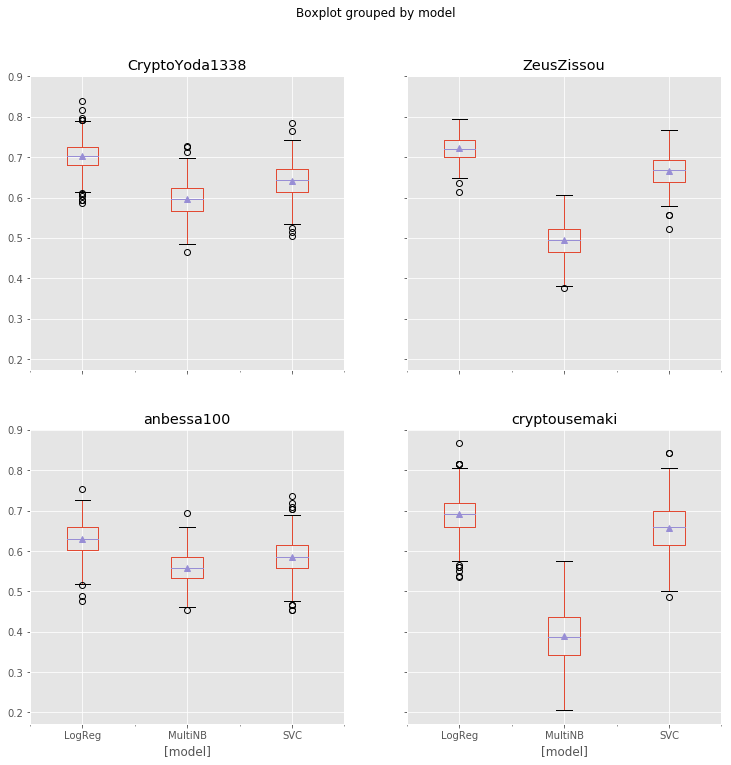

In [228]:
df_acc_res = get_all_scores(res_dict, 'full_test_accs')
df_acc_res.boxplot(by='model', figsize=(12,12), showmeans = True)

In [229]:
users = res_dict[list(res_dict.keys())[0]].keys()

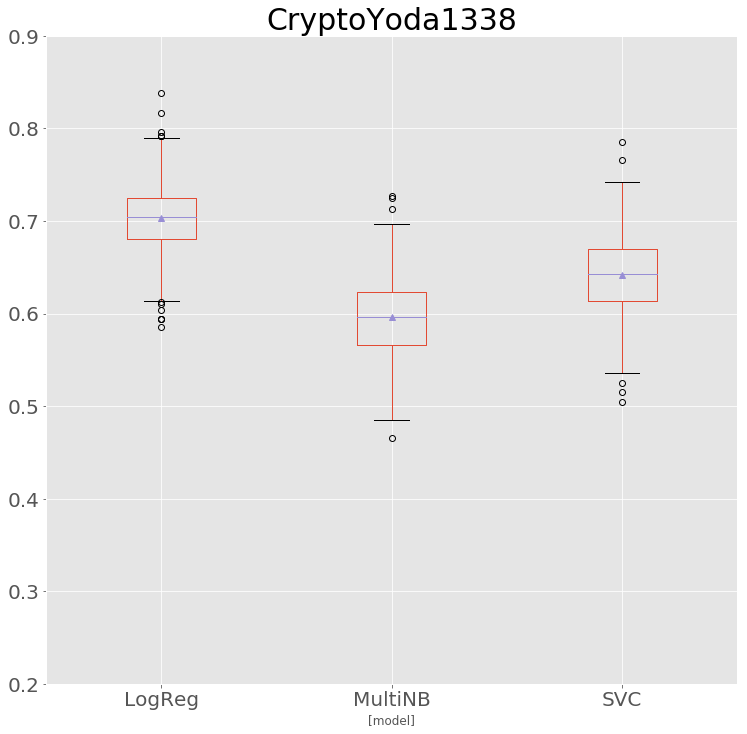

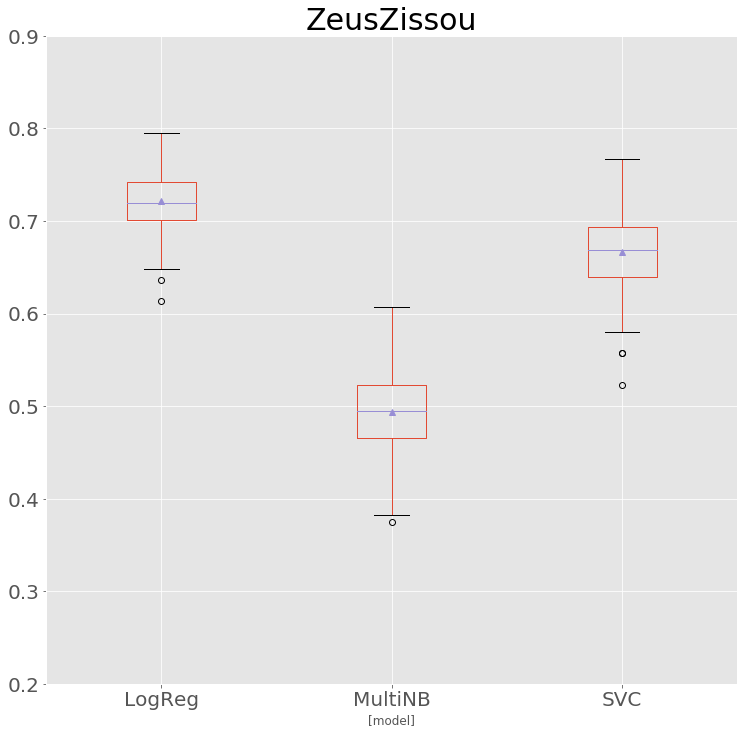

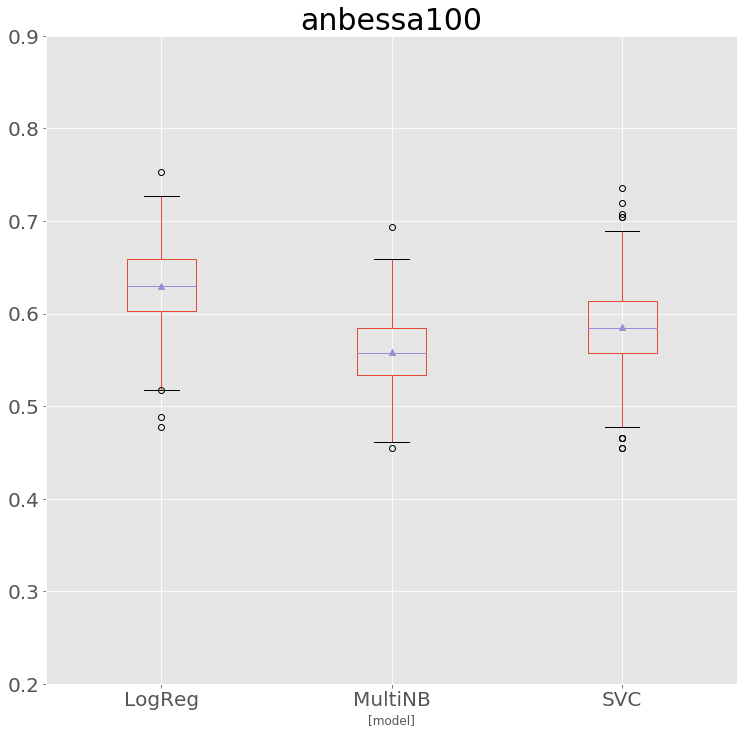

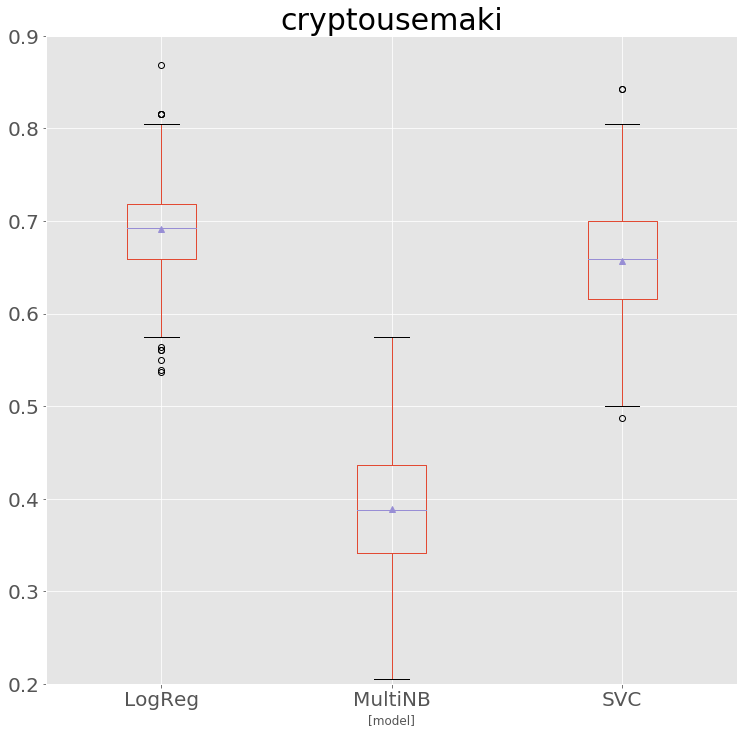

In [233]:
for user in sorted(list(users)):
    df = df_acc_res[['index',user,'model']]

    fig = plt.figure(figsize=(12,12))
    fig.subplots_adjust(top=0.9, wspace=0.3)

    ax = fig.add_subplot(1,1,1)
    df.boxplot(by = 'model', ax=ax, showmeans = True, fontsize= 30)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylim(0.2,0.9)
    ax.title.set_size(30)
    fig.texts = [] #flush the old super titles
    fig.savefig('Accuracy Plots/app8_' + user)

### 4b) Information Gain

In [24]:
df_null_res = get_all_scores(res_dict, 'full_test_null_accs')

dict_res_test_ig = {}
dict_res_test_ig['model'] = df_acc_res['model']
for user in all_users[1:5]:
    test_ig = [df_acc_res[user][pos] - df_null_res[user][pos] for pos in range(len(df_acc_res))]
    dict_res_test_ig[user] = test_ig

df_test_ig = pd.DataFrame(dict_res_test_ig)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FC3B063550>,
      dtype=object)

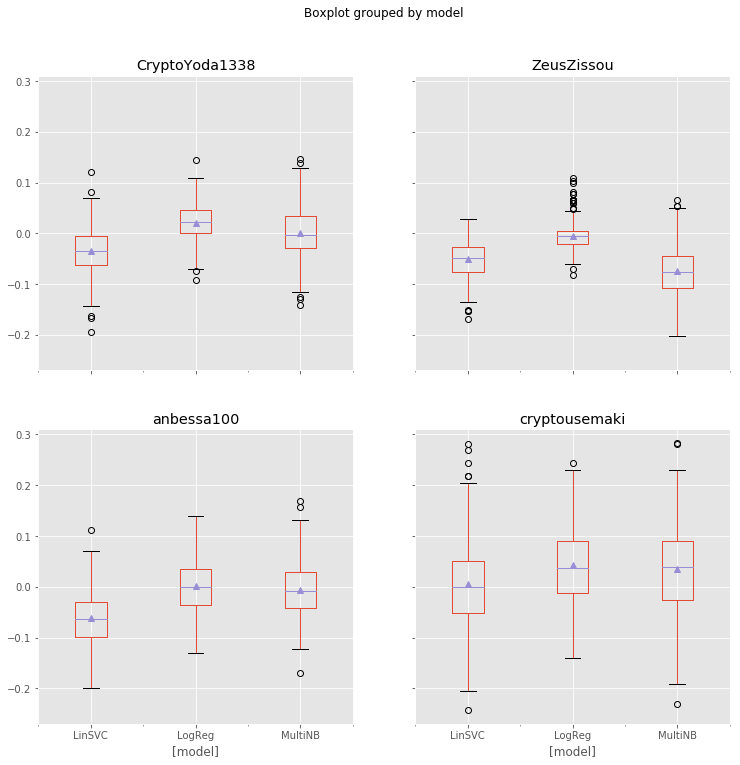

In [25]:
df_test_ig.boxplot(by='model', figsize=(12,12), showmeans = True)